In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [4]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 8
GEN_IN_CHANNELS = 1
GEN_N_CLASSES = 1
DIS_IN_CHANNELS = 1
DIS_N_CLASSES = 3
EPOCH =100

### Model Settings

#### encoder

In [5]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [6]:
DECODER_ATT = "scse"

#### head

In [7]:
GEN_ACT = "hardtanh"
DIS_ACT = "sigmoid"

### Optimizer Settings

In [8]:
GEN_OPTIM_NAME = "adabelief"
GEN_init_lr = 2e-4
GEN_momentum = 0.9

In [9]:
DIS_OPTIM_NAME = "adam"
DIS_init_lr = 3e-4
DIS_momentum = 0.9

# Epochs

In [10]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR
from codes.activation import Activation
from codes.utils import hu_clip_tensor
from codes.losses import PerceptualLoss

In [11]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
    nets (network list)   -- a list of networks
    requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

In [12]:
def train_a2b_epoch(generator, gen_optimizer, discriminator, dis_optimizer, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.train().to(device)
    discriminator = discriminator.train().to(device)

    dis_l = 0
    gen_l = 0
    ssim_l = 0
    mae_l = 0
    air_l = 0
    bone_l = 0
    perceptual_l = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
       ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        set_requires_grad(discriminator, True)
        dis_optimizer.zero_grad()

        y_cls = discriminator(y)
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = discriminator(y_pr.detach())
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        
        _dis = nn.BCELoss()(y_cls.float(), torch.ones(y_cls.size(), dtype=torch.float, device=device)) + \
                                nn.BCELoss()(y_pr_cls.float(), torch.zeros(y_pr_cls.size(), dtype=torch.float, device=device))

        _dis.backward()
        dis_optimizer.step()
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        set_requires_grad(discriminator, False)
        gen_optimizer.zero_grad()
        
        # main loss
        _mae = MAELoss()(y_pr.float(), y.float())
        _ssim =SSIMLoss()(y_pr, y, data_range=1.0, size_average=True) # return (N,)
        
        # adversarial loss
        y_pr_cls = discriminator(y_pr)
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        _gen = nn.BCELoss()(y_pr_cls.float(), torch.ones(y_pr_cls.size(), dtype=torch.float, device=device))

        # auxilary loss
        upper = ((-256) - (-500))/(500-(-500))
        lower = ((-257) - (-500))/(500-(-500))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        air_loss = nn.BCELoss()(air_pr.float(), air_x.float())
        
        upper = ((256) - (-500))/(500-(-500))
        lower = ((255) - (-500))/(500-(-500))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        bone_loss = nn.BCELoss()(bone_pr.float(), bone_x.float())

        _loss = _gen + air_loss*2 + bone_loss*5 + _mae + _ssim
        _loss.backward()    
        gen_optimizer.step()

        dis_l += _gen.item()
        gen_l += _dis.item()
        air_l += air_loss.item()
        bone_l += bone_loss.item()
        ssim_l += _ssim.item()
        mae_l += _mae.item()
        
    return  mae_l/(index+1), ssim_l/(index+1), air_l/(index+1), bone_l/(index+1), gen_l/(index+1), dis_l/(index+1)

In [13]:
@torch.no_grad()
def eval_epoch(generator, discriminator, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.eval().to(device)
    discriminator = discriminator.eval().to(device)

    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    air_ = []
    bone_ = []
    acc_ = []
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        y_cls = discriminator(y)
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = discriminator(y_pr)
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        
        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        # auxilary
        upper = ((-256) - (-500))/(500-(-500))
        lower = ((-257) - (-500))/(500-(-500))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        upper = ((256) - (-500))/(500-(-500))
        lower = ((255) - (-500))/(500-(-500))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]
        
        # adversarial
        acc = Accuracy()(y_cls, torch.ones(y_cls.size(), device=y_cls.device))
        acc_ += [acc.item()]
        acc = Accuracy()(y_pr_cls, torch.zeros(y_pr_cls.size(), device=y_pr_cls.device))
        acc_ += [acc.item()]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(acc_)/len(acc_)

In [14]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)

    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        upper = ((-256) - (-500))/(500-(-500))
        lower = ((-257) - (-500))/(500-(-500))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        
        upper = ((256) - (-500))/(500-(-500))
        lower = ((255) - (-500))/(500-(-500))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)

        for b in range(x.shape[0]):
            
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            
            __cbct = (x.squeeze().cpu().numpy()[b, :, :] * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                
            iid += 1

# Discriminator

In [15]:
from codes.activation import Activation
import torchvision.models as models

In [16]:
class Model(nn.Module):
    def __init__(self, in_channel=1, n_classes=2, activation=None):
        
        super(Model, self).__init__()
        
        encoder = models.resnet152()
        encoder.conv1 = nn.Conv2d(in_channel, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        encoder.fc = nn.Linear(in_features=2048, out_features=n_classes)
        self.encoder = encoder
        self.activation = Activation(name=activation)
        
        
    def forward(self, x):
        x = self.encoder(x)
        return self.activation(x)

# Read Data

In [17]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [18]:
train_case_path = 'raw/train/*_*'
test_case_path = 'raw/test/*_*'

In [19]:
trainset = Dataset(path=train_case_path, geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, geometry_aug=aug.get_validation_augmentation())

In [20]:
len(trainset), len(testset)

(1344, 191)

In [21]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7f15353b37c0>,)

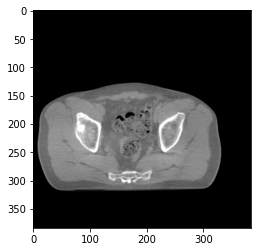

In [22]:
plt.imshow(x.squeeze(), 'gray'),

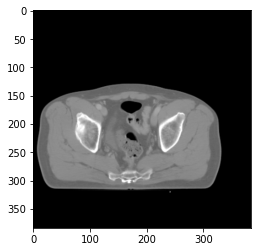

In [23]:
plt.imshow(y.squeeze(), 'gray')

In [24]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# training

In [25]:
import wandb

wandb.init(project="cbct_gan", config={
    "data": {
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "in_channels": GEN_IN_CHANNELS,
        "out_channels": GEN_N_CLASSES,
        "optimizer": GEN_OPTIM_NAME,
        "init_lr": GEN_init_lr,
        "momentum": GEN_momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": GEN_ACT,
        "decoder_attention_type": DECODER_ATT
    },
    "discriminator": {
        "in_channels": DIS_IN_CHANNELS,
        "out_channels": DIS_N_CLASSES,
        "optimizer": DIS_OPTIM_NAME,
        "init_lr": DIS_init_lr,
        "momentum": DIS_momentum,
        "encoder": "resnet152"
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [26]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [27]:
import segmentation_models_pytorch as smp
import torchvision.models as models

model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=GEN_IN_CHANNELS, classes=GEN_N_CLASSES)

In [28]:
discriminator = Model(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [29]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
gen_optimizer = Optimizer(model.parameters(), name=GEN_OPTIM_NAME)
dis_optimizer = Optimizer(discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)

Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief


In [30]:
wandb.watch(model)
wandb.watch(discriminator)

max_score = 0

for epoch in range(EPOCH):
        
        loss_mae, loss_ssim, loss_air, loss_bone, loss_gen, loss_dis = train_a2b_epoch(model, gen_optimizer, discriminator, dis_optimizer, trainloader, device)
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, score_air_train, score_bone_train, score_acc_train = eval_epoch(model, discriminator, trainloader, device)
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_air_test, score_bone_test, score_acc_test = eval_epoch(model, discriminator, testloader, device)

        
        wandb.log({
            "loss ssim": loss_ssim,
            "loss mae": loss_mae,
            "loss mask": loss_air,
            "loss bone": loss_bone,
            "loss gen": loss_gen,
            "loss dis": loss_dis,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "trainset acc score": score_acc_train,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
            "testset acc score": score_acc_test
        })
        
        
        if score_bone_test +  score_air_test >  max_score:
            max_score = score_bone_test +  score_air_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": gen_optimizer.state_dict(),
                "dicriminator": discriminator.state_dict(),
                "dis_optim": dis_optimizer.state_dict()
            }
            torch.save(checkpoint, os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

168it [02:30,  1.12it/s]
168it [00:37,  4.48it/s]
24it [00:05,  4.24it/s]
168it [02:31,  1.11it/s]
168it [00:37,  4.44it/s]
24it [00:05,  4.23it/s]
168it [02:31,  1.11it/s]
168it [00:37,  4.45it/s]
24it [00:05,  4.22it/s]
168it [02:31,  1.11it/s]
168it [00:37,  4.45it/s]
24it [00:05,  4.22it/s]
168it [02:31,  1.11it/s]
168it [00:37,  4.45it/s]
24it [00:05,  4.22it/s]
168it [02:31,  1.11it/s]
168it [00:37,  4.45it/s]
24it [00:05,  4.22it/s]
168it [02:31,  1.11it/s]
168it [00:37,  4.45it/s]
24it [00:05,  4.22it/s]
168it [02:31,  1.11it/s]
168it [00:37,  4.44it/s]
24it [00:05,  4.21it/s]
168it [02:31,  1.11it/s]
168it [00:37,  4.47it/s]
24it [00:05,  4.22it/s]
168it [02:31,  1.11it/s]
168it [00:37,  4.45it/s]
24it [00:05,  4.20it/s]
168it [02:31,  1.11it/s]
168it [00:37,  4.47it/s]
24it [00:05,  4.23it/s]
168it [02:31,  1.11it/s]
168it [00:37,  4.45it/s]
24it [00:05,  4.22it/s]
168it [02:31,  1.11it/s]
168it [00:37,  4.46it/s]
24it [00:05,  4.22it/s]
168it [02:31,  1.11it/s]
168it [00:37,

KeyboardInterrupt: 

In [31]:
checkpoint = torch.load(os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

In [32]:
model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=GEN_IN_CHANNELS, classes=GEN_N_CLASSES)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [33]:
os.mkdir(os.path.join("eval-gan", wandb.run.name))

0it [00:00, ?it/s]

ssim score = 0.9103681445121765
psnr score = 26.635255813598633
snr score = 16.698192596435547
mae error = 0.013552190735936165
air dice score = 0.9856196802363703
bone dice score = 0.9518381305222023


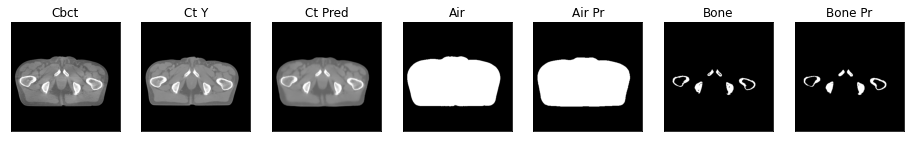

ssim score = 0.9096210598945618
psnr score = 26.667566299438477
snr score = 16.778039932250977
mae error = 0.01378591824322939
air dice score = 0.9858951755089098
bone dice score = 0.9427609427617458


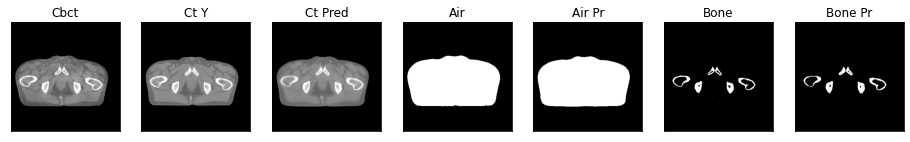

ssim score = 0.9032965302467346
psnr score = 26.350812911987305
snr score = 16.624181747436523
mae error = 0.014713090844452381
air dice score = 0.9886584510570197
bone dice score = 0.9345860246631287


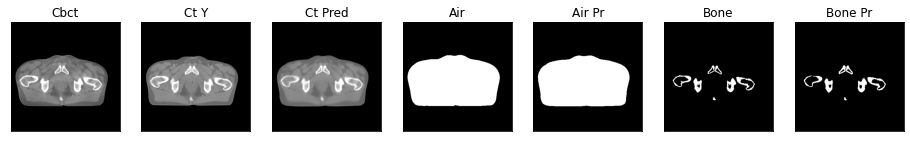

ssim score = 0.903989851474762
psnr score = 26.72177505493164
snr score = 17.08439826965332
mae error = 0.01450030505657196
air dice score = 0.9881882645989553
bone dice score = 0.9379105742748685


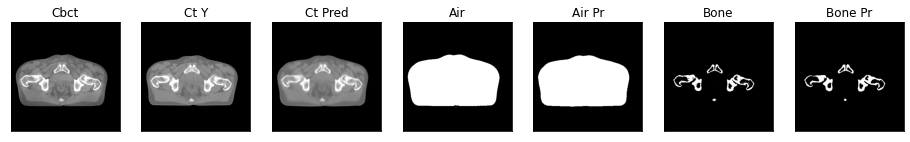

ssim score = 0.9009960293769836
psnr score = 26.39415740966797
snr score = 16.797082901000977
mae error = 0.014871281571686268
air dice score = 0.9901660486861296
bone dice score = 0.9403998491141041


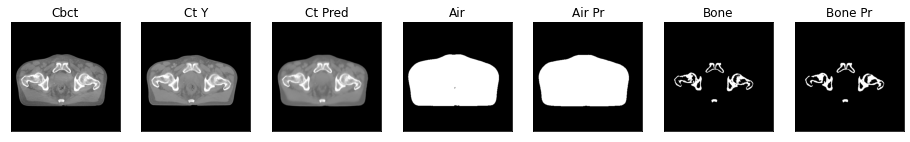

ssim score = 0.8929508328437805
psnr score = 26.120641708374023
snr score = 16.66010093688965
mae error = 0.01566300168633461
air dice score = 0.9914488446843437
bone dice score = 0.9391430179279754


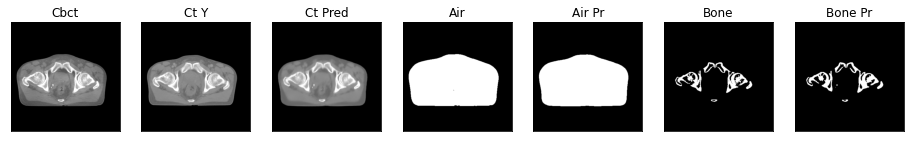

ssim score = 0.8913359642028809
psnr score = 26.115949630737305
snr score = 16.631349563598633
mae error = 0.015759184956550598
air dice score = 0.9909213044009375
bone dice score = 0.9478774852233985


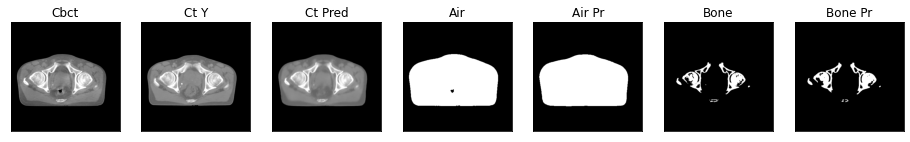

ssim score = 0.8903014063835144
psnr score = 26.06534194946289
snr score = 16.39520835876465
mae error = 0.015696445479989052
air dice score = 0.9912013848344332
bone dice score = 0.9518853437983972


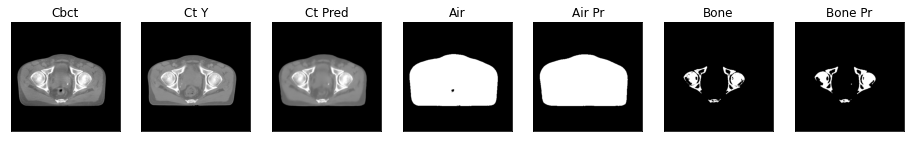

1it [00:02,  2.58s/it]

ssim score = 0.8947885632514954
psnr score = 26.30483627319336
snr score = 16.54014778137207
mae error = 0.015130187384784222
air dice score = 0.9910855069924757
bone dice score = 0.9566840926068271


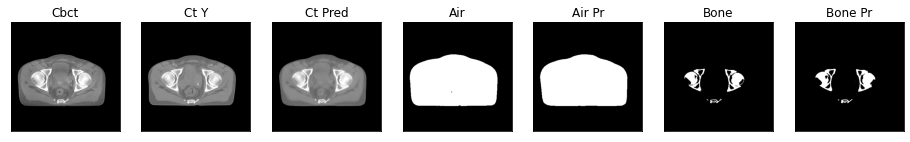

ssim score = 0.8958634734153748
psnr score = 26.35214614868164
snr score = 16.572174072265625
mae error = 0.014784516766667366
air dice score = 0.9916252072968578
bone dice score = 0.9525380957007421


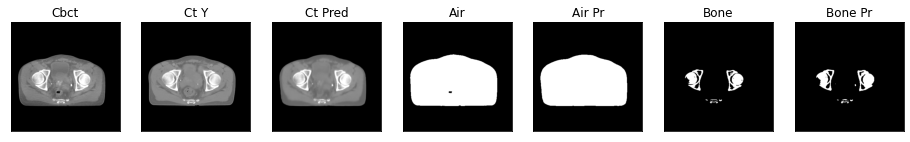

ssim score = 0.8989138007164001
psnr score = 26.51172637939453
snr score = 16.764022827148438
mae error = 0.01450794655829668
air dice score = 0.992368955286042
bone dice score = 0.9558929862622054


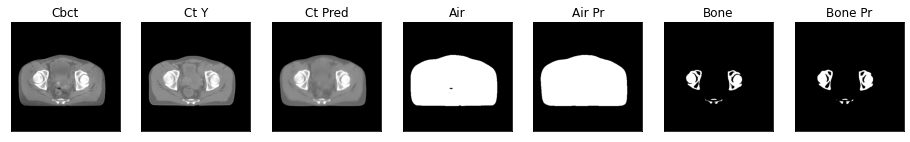

ssim score = 0.9009900689125061
psnr score = 26.730018615722656
snr score = 17.006025314331055
mae error = 0.01418568380177021
air dice score = 0.9902598426024289
bone dice score = 0.9657598013865133


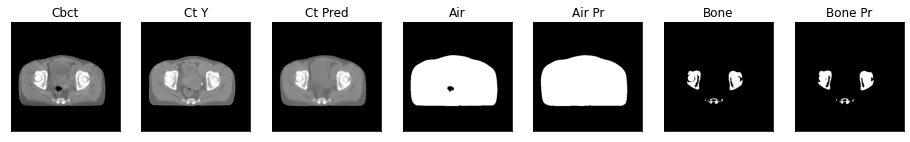

ssim score = 0.9077759981155396
psnr score = 26.91480255126953
snr score = 17.158885955810547
mae error = 0.013961048796772957
air dice score = 0.9869658822157078
bone dice score = 0.9732871353529308


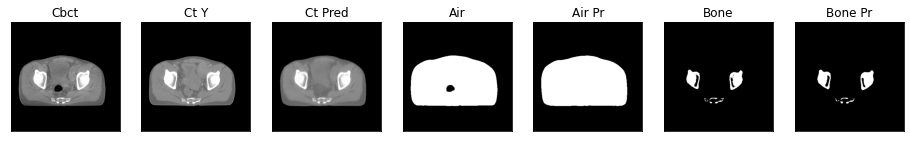

ssim score = 0.9121806621551514
psnr score = 27.43830108642578
snr score = 17.540430068969727
mae error = 0.01368875615298748
air dice score = 0.9846147252935795
bone dice score = 0.9591141396938535


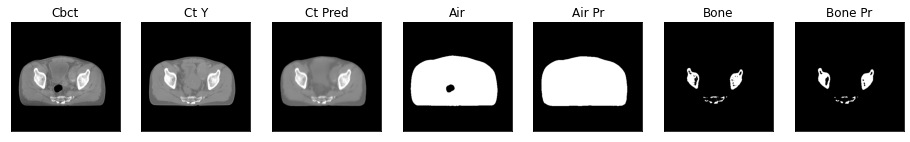

ssim score = 0.909970760345459
psnr score = 27.264842987060547
snr score = 17.281309127807617
mae error = 0.014016249217092991
air dice score = 0.9836766882366462
bone dice score = 0.9447868515672215


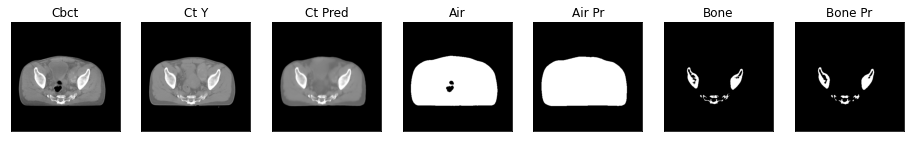

ssim score = 0.9046726822853088
psnr score = 26.81414031982422
snr score = 16.854093551635742
mae error = 0.014634308405220509
air dice score = 0.9848568850623609
bone dice score = 0.9525211630480613


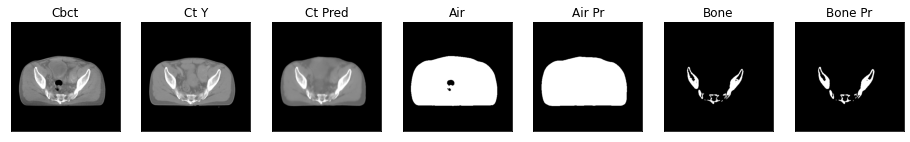

2it [00:04,  2.49s/it]

ssim score = 0.9030030965805054
psnr score = 26.51290512084961
snr score = 16.550312042236328
mae error = 0.01491585187613964
air dice score = 0.9809958734525657
bone dice score = 0.9523586012678671


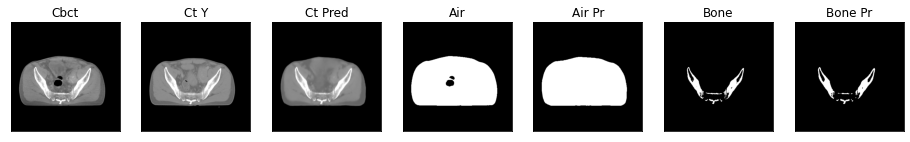

ssim score = 0.8995372653007507
psnr score = 26.447391510009766
snr score = 16.383039474487305
mae error = 0.014969663694500923
air dice score = 0.9758990480012754
bone dice score = 0.9343379978479327


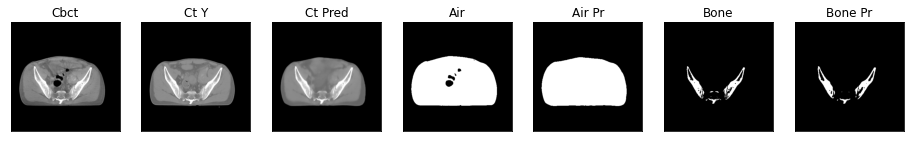

ssim score = 0.8975005745887756
psnr score = 25.834270477294922
snr score = 15.719236373901367
mae error = 0.015602139756083488
air dice score = 0.9764956062873674
bone dice score = 0.9220717510106666


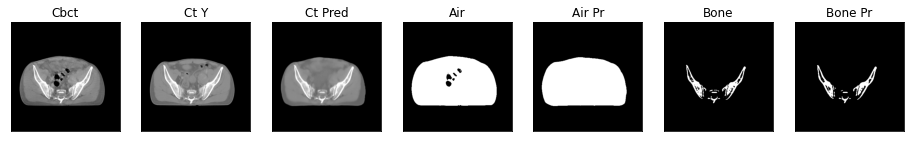

ssim score = 0.893418550491333
psnr score = 25.198915481567383
snr score = 15.071572303771973
mae error = 0.01662917248904705
air dice score = 0.9785311247601883
bone dice score = 0.93293413173733


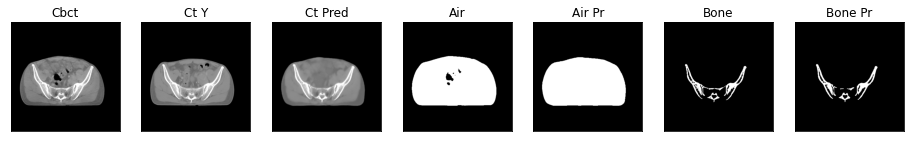

ssim score = 0.8904637098312378
psnr score = 24.817691802978516
snr score = 14.625497817993164
mae error = 0.017361057922244072
air dice score = 0.9830027355866826
bone dice score = 0.9174311926616326


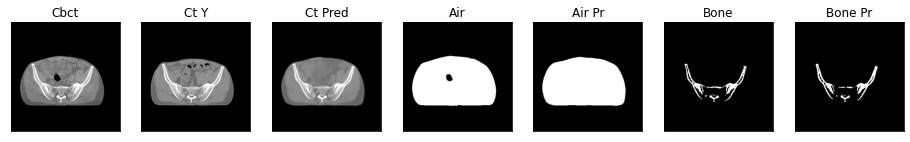

ssim score = 0.8879412412643433
psnr score = 24.378145217895508
snr score = 14.126523971557617
mae error = 0.017632190138101578
air dice score = 0.9815458802800789
bone dice score = 0.9333164300211294


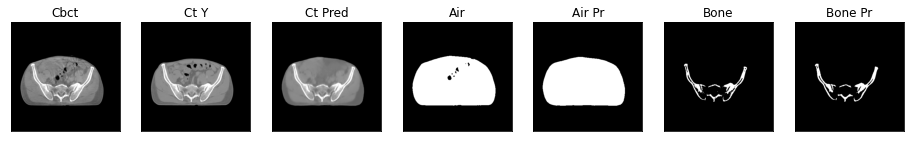

ssim score = 0.8921433687210083
psnr score = 24.300527572631836
snr score = 14.01547908782959
mae error = 0.017560020089149475
air dice score = 0.9828111809398945
bone dice score = 0.9373445457783092


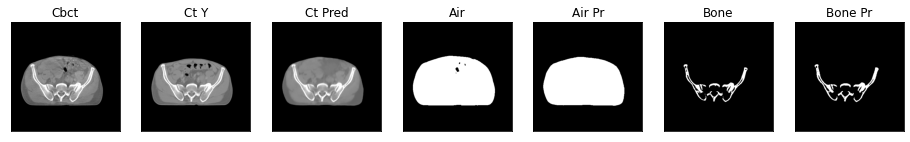

ssim score = 0.8911544680595398
psnr score = 23.953561782836914
snr score = 13.619946479797363
mae error = 0.01840607263147831
air dice score = 0.9851251806059059
bone dice score = 0.9314128943766413


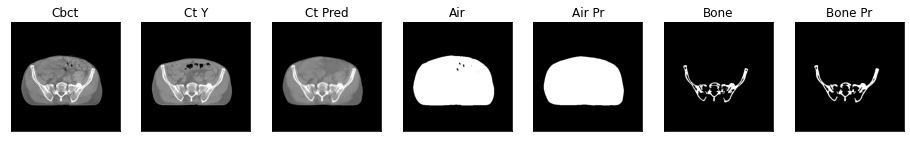

3it [00:06,  2.36s/it]

ssim score = 0.8897526860237122
psnr score = 23.69440460205078
snr score = 13.263792037963867
mae error = 0.01907321810722351
air dice score = 0.9889846456268336
bone dice score = 0.9358820316773798


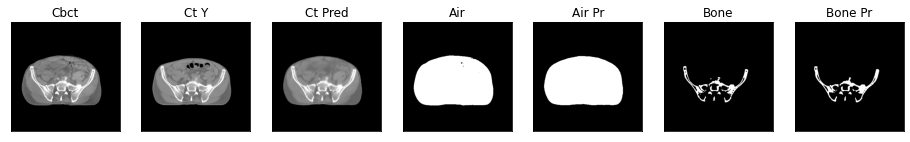

ssim score = 0.8912122249603271
psnr score = 24.029075622558594
snr score = 13.515727996826172
mae error = 0.018343163654208183
air dice score = 0.9870053521782423
bone dice score = 0.9259707402934114


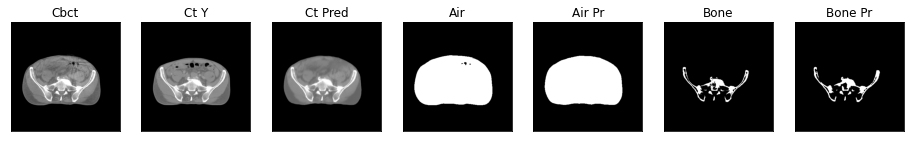

ssim score = 0.889672577381134
psnr score = 23.97160530090332
snr score = 13.367072105407715
mae error = 0.018606409430503845
air dice score = 0.9854083901756673
bone dice score = 0.9351149118125589


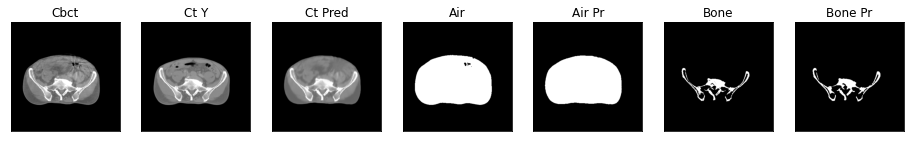

ssim score = 0.8912772536277771
psnr score = 23.88292121887207
snr score = 13.23728084564209
mae error = 0.019101951271295547
air dice score = 0.9852133181415557
bone dice score = 0.9338600222836639


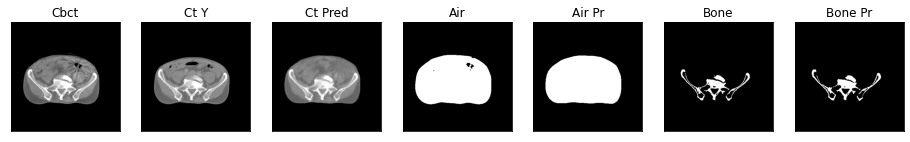

ssim score = 0.874273955821991
psnr score = 23.73647689819336
snr score = 15.108633995056152
mae error = 0.01976323127746582
air dice score = 0.9879767618085451
bone dice score = 0.984605717876701


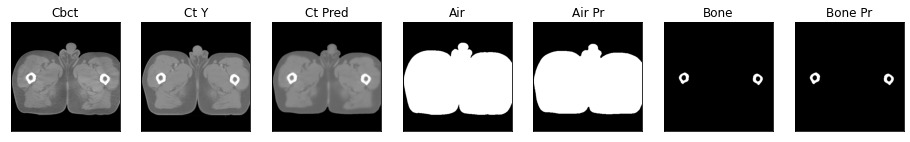

ssim score = 0.8753201961517334
psnr score = 24.100383758544922
snr score = 15.511800765991211
mae error = 0.01911947689950466
air dice score = 0.9867100895597253
bone dice score = 0.9811985898947944


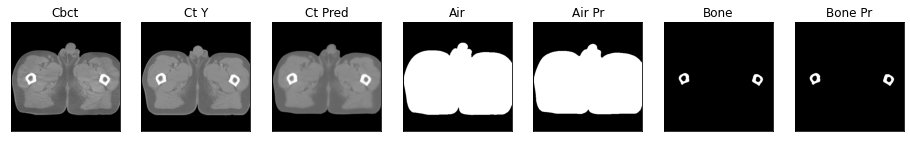

ssim score = 0.8796380758285522
psnr score = 24.490497589111328
snr score = 15.989361763000488
mae error = 0.018835902214050293
air dice score = 0.9862070251555602
bone dice score = 0.9665252239517557


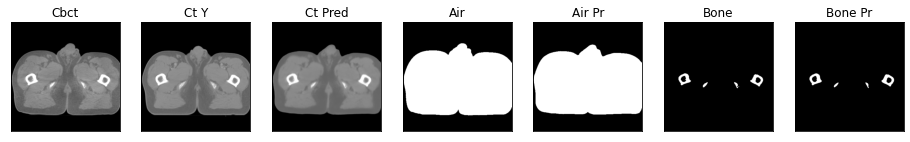

ssim score = 0.8859783411026001
psnr score = 25.141504287719727
snr score = 16.80292320251465
mae error = 0.018505217507481575
air dice score = 0.9883467982967047
bone dice score = 0.969262621437024


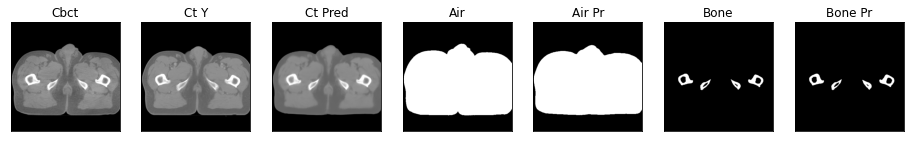

4it [00:09,  2.33s/it]

ssim score = 0.8914068341255188
psnr score = 25.52199363708496
snr score = 17.31155776977539
mae error = 0.01790883019566536
air dice score = 0.9916987790159888
bone dice score = 0.9635036496355391


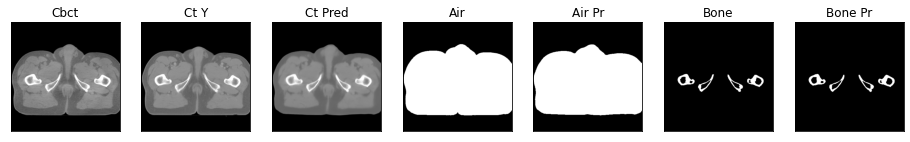

ssim score = 0.8950657844543457
psnr score = 26.01902198791504
snr score = 17.91182518005371
mae error = 0.017311017960309982
air dice score = 0.9928058430443328
bone dice score = 0.9619708203783547


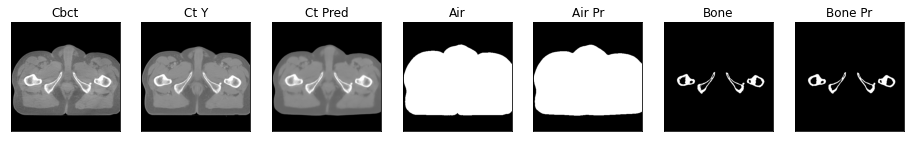

ssim score = 0.8962408900260925
psnr score = 26.478605270385742
snr score = 18.438508987426758
mae error = 0.017107347026467323
air dice score = 0.9928376927788704
bone dice score = 0.95623846237424


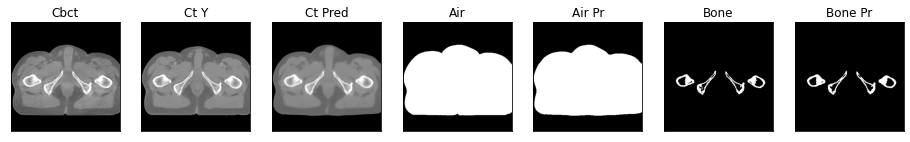

ssim score = 0.8935834169387817
psnr score = 26.541383743286133
snr score = 18.491395950317383
mae error = 0.017250189557671547
air dice score = 0.9934689488088876
bone dice score = 0.9613680848875928


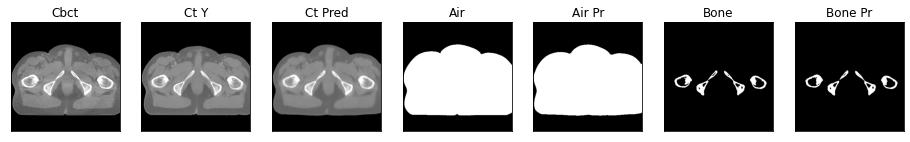

ssim score = 0.9010153412818909
psnr score = 26.846162796020508
snr score = 18.78251075744629
mae error = 0.016820497810840607
air dice score = 0.9945075152384832
bone dice score = 0.963543788187744


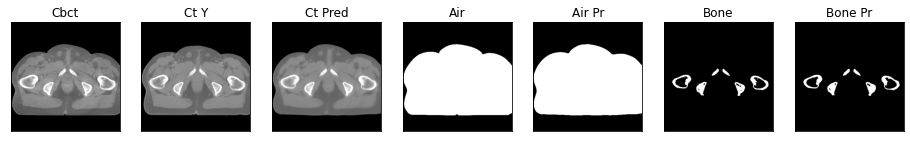

ssim score = 0.8976300358772278
psnr score = 26.765605926513672
snr score = 18.713956832885742
mae error = 0.01720290258526802
air dice score = 0.9945267863043524
bone dice score = 0.9478827361569176


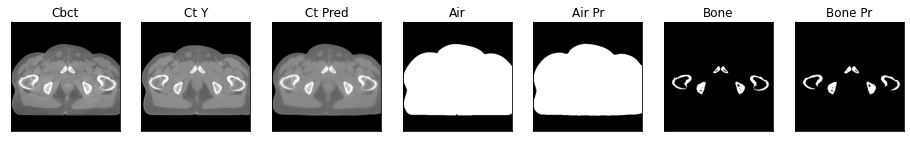

ssim score = 0.9003629088401794
psnr score = 27.044307708740234
snr score = 19.031742095947266
mae error = 0.016868218779563904
air dice score = 0.9938660636967226
bone dice score = 0.954398483666469


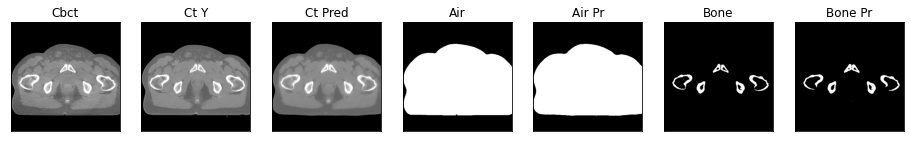

ssim score = 0.902116060256958
psnr score = 27.404735565185547
snr score = 19.533458709716797
mae error = 0.016752004623413086
air dice score = 0.9941803431611544
bone dice score = 0.9518838379049835


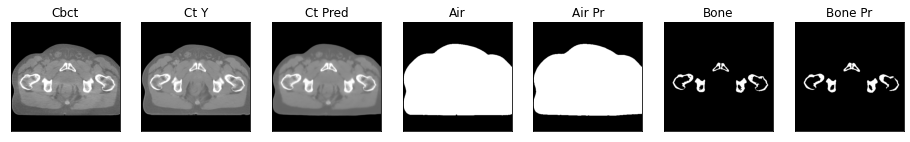

5it [00:11,  2.26s/it]

ssim score = 0.9007425904273987
psnr score = 27.408599853515625
snr score = 19.63201141357422
mae error = 0.017131229862570763
air dice score = 0.9932419409242078
bone dice score = 0.955177015464674


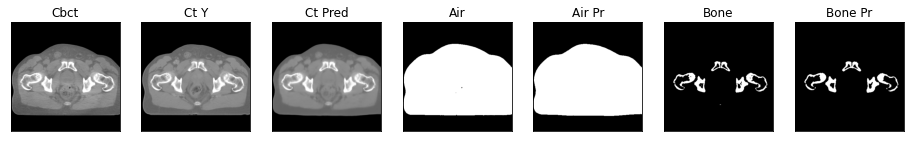

ssim score = 0.8971627950668335
psnr score = 27.35996437072754
snr score = 19.54932975769043
mae error = 0.017610255628824234
air dice score = 0.9924314382687339
bone dice score = 0.9336507448937671


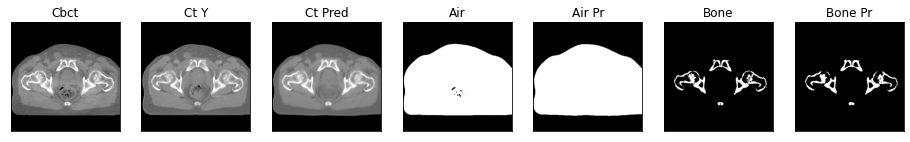

ssim score = 0.8929122090339661
psnr score = 26.98247718811035
snr score = 19.24402618408203
mae error = 0.01860995776951313
air dice score = 0.9898604289257465
bone dice score = 0.918872532840987


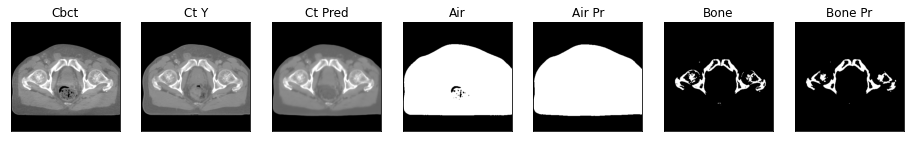

ssim score = 0.8919898271560669
psnr score = 26.996456146240234
snr score = 19.121910095214844
mae error = 0.017972655594348907
air dice score = 0.9899209160808096
bone dice score = 0.9068762957851859


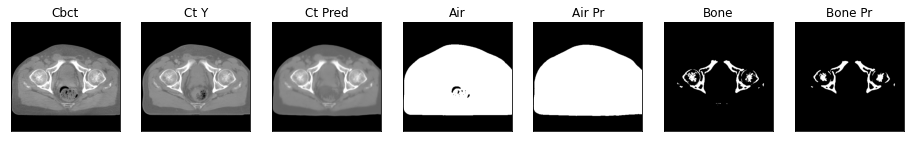

ssim score = 0.8958466649055481
psnr score = 26.798233032226562
snr score = 18.745128631591797
mae error = 0.01763812266290188
air dice score = 0.9907494762120693
bone dice score = 0.916176328736219


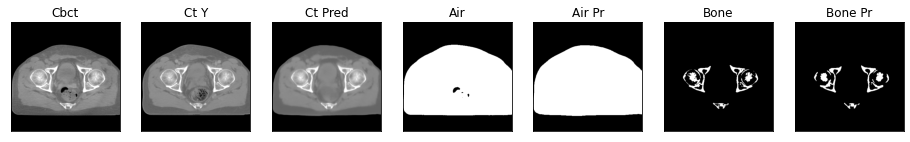

ssim score = 0.888931155204773
psnr score = 25.865564346313477
snr score = 17.72187042236328
mae error = 0.018940601497888565
air dice score = 0.991074559110291
bone dice score = 0.9114549752857141


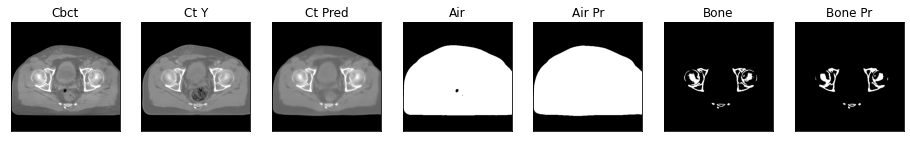

ssim score = 0.8871837258338928
psnr score = 25.675249099731445
snr score = 17.547245025634766
mae error = 0.018839577212929726
air dice score = 0.9917458435970146
bone dice score = 0.9216022601158147


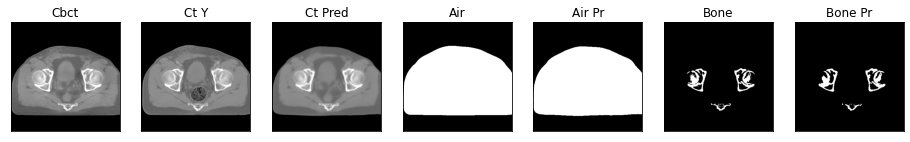

ssim score = 0.8815093040466309
psnr score = 25.85729217529297
snr score = 17.739322662353516
mae error = 0.019347870722413063
air dice score = 0.9923329546371704
bone dice score = 0.9276464728794019


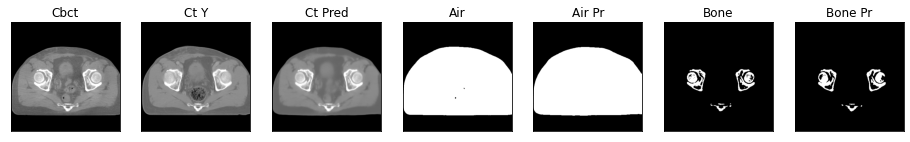

6it [00:13,  2.26s/it]

ssim score = 0.8878123164176941
psnr score = 26.278301239013672
snr score = 18.221920013427734
mae error = 0.018291078507900238
air dice score = 0.9923894983789616
bone dice score = 0.9511958344369323


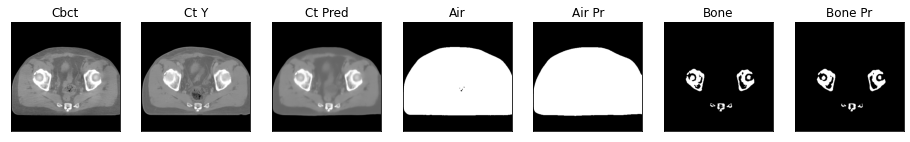

ssim score = 0.8903595805168152
psnr score = 27.05896759033203
snr score = 19.072669982910156
mae error = 0.01752261258661747
air dice score = 0.9920024972686174
bone dice score = 0.9683002056205594


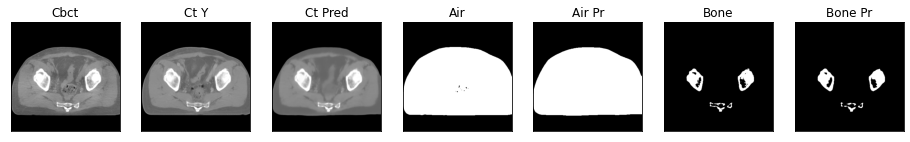

ssim score = 0.8928960561752319
psnr score = 26.61058235168457
snr score = 18.505176544189453
mae error = 0.01813296414911747
air dice score = 0.9917884863963683
bone dice score = 0.9575954819569484


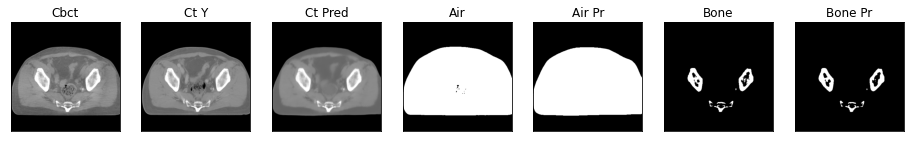

ssim score = 0.8857396245002747
psnr score = 26.1228084564209
snr score = 18.09903335571289
mae error = 0.019754881039261818
air dice score = 0.9914475649835727
bone dice score = 0.9656143839591879


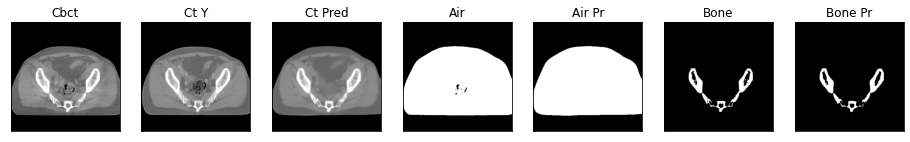

ssim score = 0.8869999647140503
psnr score = 26.349037170410156
snr score = 18.405410766601562
mae error = 0.01965501345694065
air dice score = 0.9912366235847294
bone dice score = 0.9644761443115818


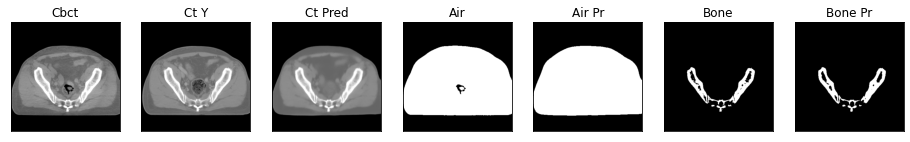

ssim score = 0.8764931559562683
psnr score = 26.09536361694336
snr score = 18.17329216003418
mae error = 0.020851589739322662
air dice score = 0.9912448835742693
bone dice score = 0.9513747988529254


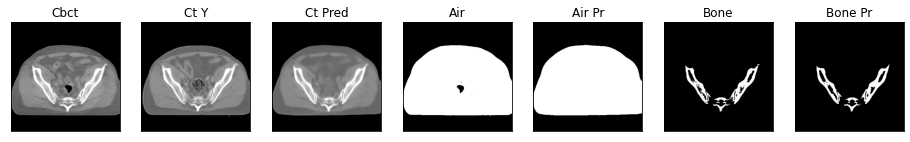

ssim score = 0.8830634951591492
psnr score = 26.35967445373535
snr score = 18.45014190673828
mae error = 0.020382104441523552
air dice score = 0.9923415590661929
bone dice score = 0.9600849256903037


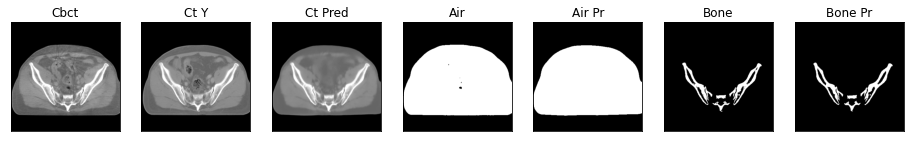

ssim score = 0.8196191191673279
psnr score = 20.776214599609375
snr score = 10.656423568725586
mae error = 0.032316602766513824
air dice score = 0.9679637908120413
bone dice score = 0.9661108122655699


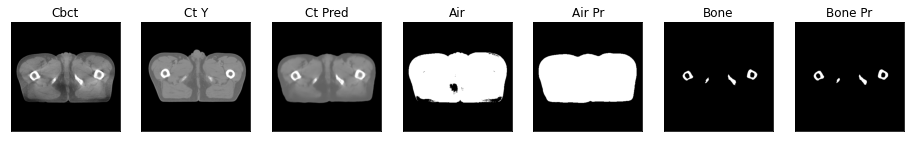

7it [00:15,  2.27s/it]

ssim score = 0.8060872554779053
psnr score = 20.404216766357422
snr score = 10.497406959533691
mae error = 0.035044629126787186
air dice score = 0.9690265078472002
bone dice score = 0.9485961123121254


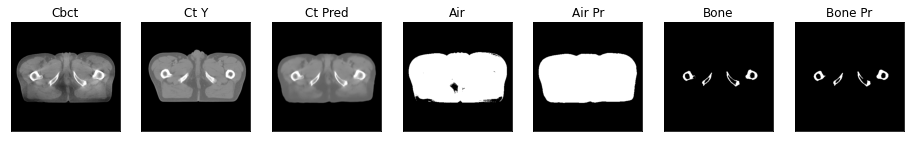

ssim score = 0.7973871231079102
psnr score = 20.448036193847656
snr score = 10.67236328125
mae error = 0.03537480905652046
air dice score = 0.9702502062139399
bone dice score = 0.9218620116391966


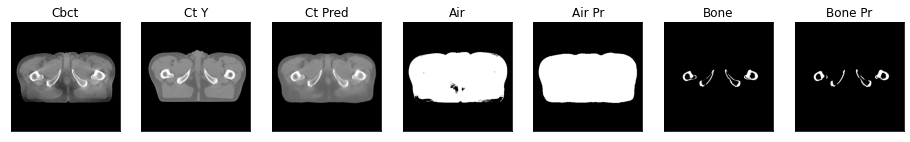

ssim score = 0.798703670501709
psnr score = 20.691516876220703
snr score = 10.986246109008789
mae error = 0.03453199937939644
air dice score = 0.9672533431368344
bone dice score = 0.9191029235098297


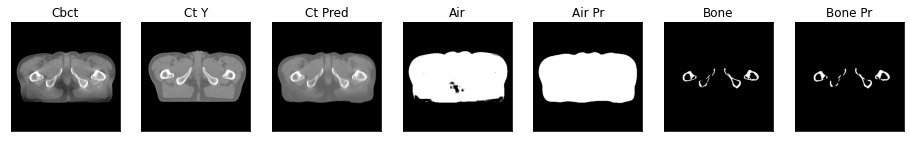

ssim score = 0.7987094521522522
psnr score = 20.713794708251953
snr score = 11.05609130859375
mae error = 0.03475290909409523
air dice score = 0.9682168194792733
bone dice score = 0.9118891881509833


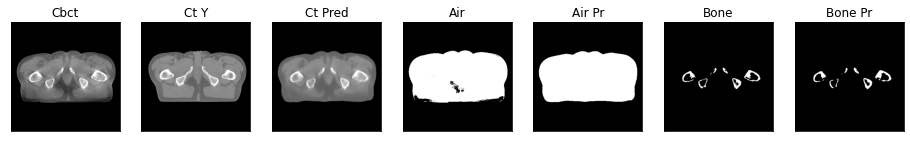

ssim score = 0.7937998175621033
psnr score = 20.687026977539062
snr score = 11.034937858581543
mae error = 0.03464173525571823
air dice score = 0.9711521661164662
bone dice score = 0.9155008393972113


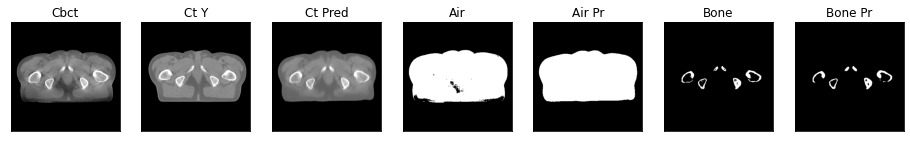

ssim score = 0.7965779304504395
psnr score = 20.736896514892578
snr score = 11.07830810546875
mae error = 0.03417491912841797
air dice score = 0.9717844223636872
bone dice score = 0.9325176121629122


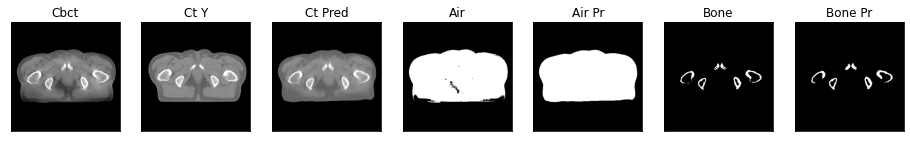

ssim score = 0.8000059127807617
psnr score = 20.74233627319336
snr score = 11.097855567932129
mae error = 0.03375609591603279
air dice score = 0.9740891203388372
bone dice score = 0.9303073624029609


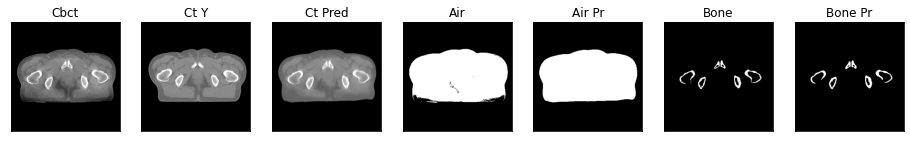

ssim score = 0.8030312061309814
psnr score = 20.901447296142578
snr score = 11.314972877502441
mae error = 0.03358392044901848
air dice score = 0.9727793307460827
bone dice score = 0.9176242110387178


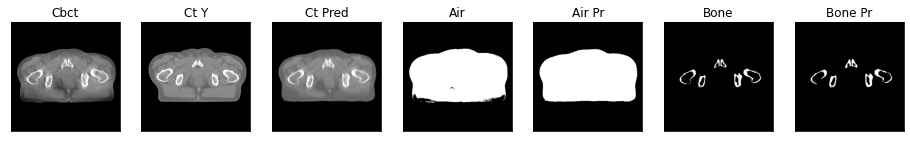

8it [00:17,  2.20s/it]

ssim score = 0.7955121397972107
psnr score = 20.684297561645508
snr score = 11.196383476257324
mae error = 0.03585593029856682
air dice score = 0.9759677885310054
bone dice score = 0.9010954119717242


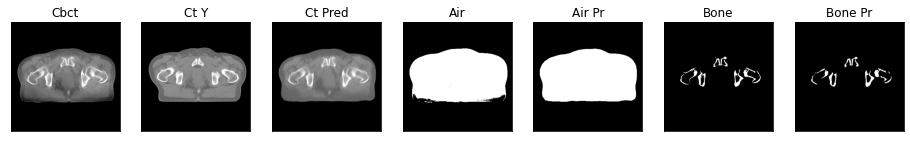

ssim score = 0.7869454622268677
psnr score = 20.581642150878906
snr score = 11.129555702209473
mae error = 0.036864250898361206
air dice score = 0.9745094509451174
bone dice score = 0.902544264247842


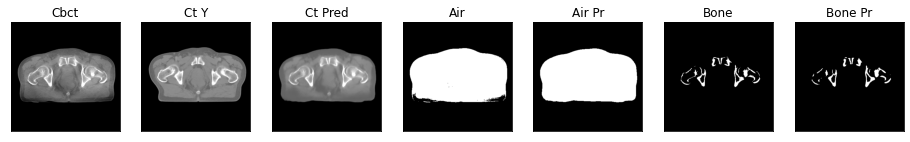

ssim score = 0.7806457877159119
psnr score = 20.61537742614746
snr score = 11.195999145507812
mae error = 0.0368431955575943
air dice score = 0.9750966272385907
bone dice score = 0.8831445702880327


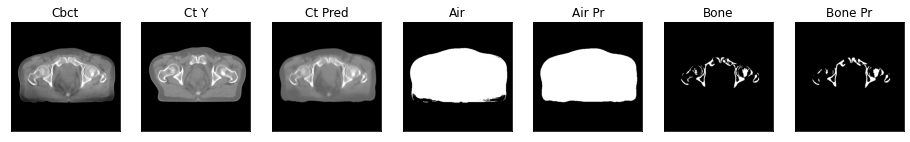

ssim score = 0.779929518699646
psnr score = 20.497827529907227
snr score = 11.195266723632812
mae error = 0.03781940042972565
air dice score = 0.9733342903799116
bone dice score = 0.8869424605863503


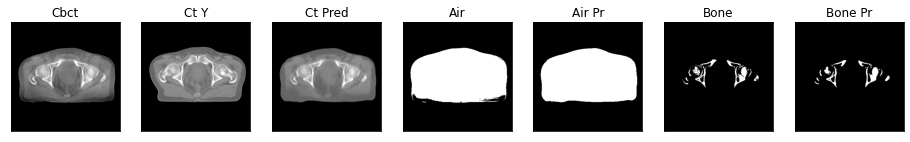

ssim score = 0.7822058796882629
psnr score = 20.48508071899414
snr score = 11.166534423828125
mae error = 0.037761736661195755
air dice score = 0.974810497711693
bone dice score = 0.8727439583990098


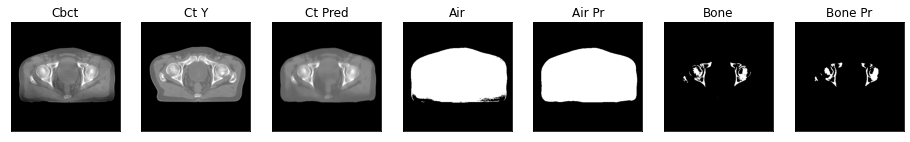

ssim score = 0.7960032224655151
psnr score = 21.0281925201416
snr score = 11.510480880737305
mae error = 0.034284260123968124
air dice score = 0.973561375378609
bone dice score = 0.9056725052240773


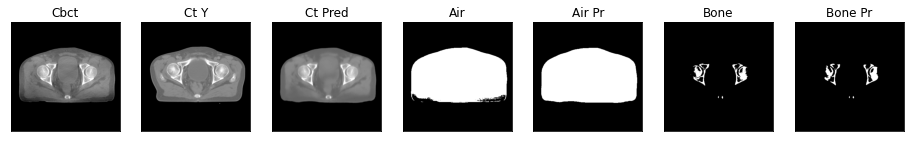

ssim score = 0.8114058375358582
psnr score = 21.712451934814453
snr score = 12.024346351623535
mae error = 0.03103390708565712
air dice score = 0.9734417344173678
bone dice score = 0.9366873940088088


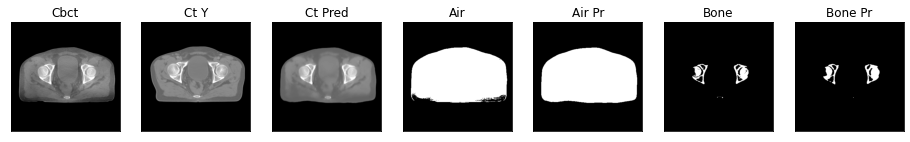

ssim score = 0.8216943740844727
psnr score = 22.266063690185547
snr score = 12.59212589263916
mae error = 0.02865777350962162
air dice score = 0.9727587034387379
bone dice score = 0.9446279899571214


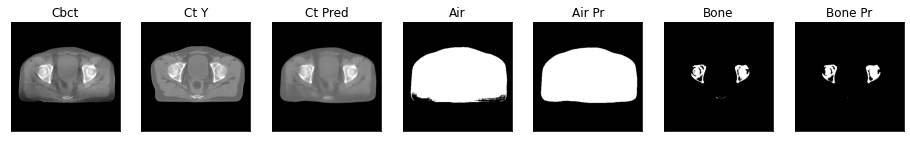

9it [00:20,  2.22s/it]

ssim score = 0.8247385025024414
psnr score = 22.39502716064453
snr score = 12.802919387817383
mae error = 0.028387589380145073
air dice score = 0.97167705619239
bone dice score = 0.9635153129165976


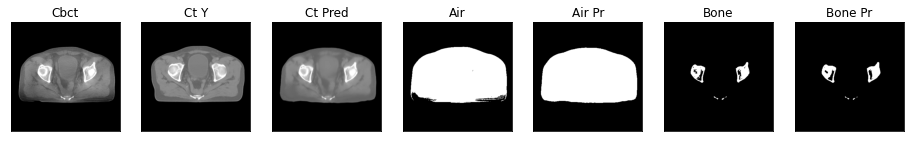

ssim score = 0.8230243921279907
psnr score = 22.19247817993164
snr score = 12.692543029785156
mae error = 0.02938210964202881
air dice score = 0.9685473036097476
bone dice score = 0.9464872944701571


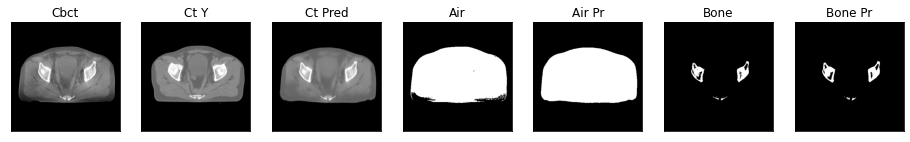

ssim score = 0.8201550841331482
psnr score = 22.504003524780273
snr score = 12.940641403198242
mae error = 0.028358718380331993
air dice score = 0.9688277761107366
bone dice score = 0.9597260720697909


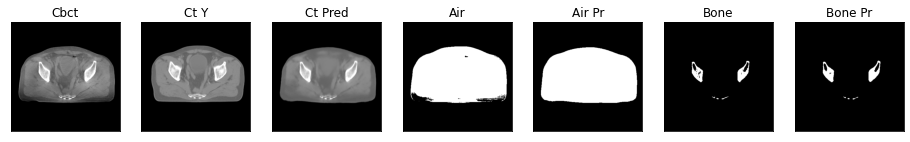

ssim score = 0.8251222372055054
psnr score = 22.88269805908203
snr score = 13.282941818237305
mae error = 0.026521820574998856
air dice score = 0.9681976928775812
bone dice score = 0.9553851516215514


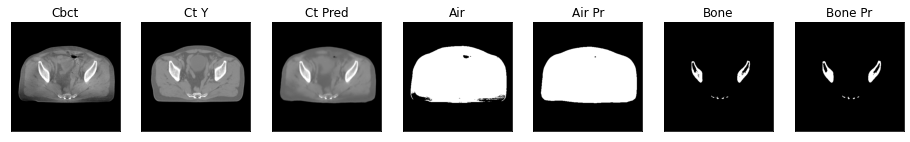

ssim score = 0.8228182792663574
psnr score = 22.623289108276367
snr score = 13.061277389526367
mae error = 0.028362639248371124
air dice score = 0.967520432119497
bone dice score = 0.9345946827608124


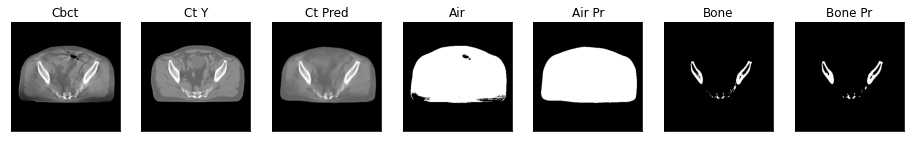

ssim score = 0.8220793008804321
psnr score = 22.459606170654297
snr score = 13.02810287475586
mae error = 0.029280198737978935
air dice score = 0.9699516147579677
bone dice score = 0.9359139784955425


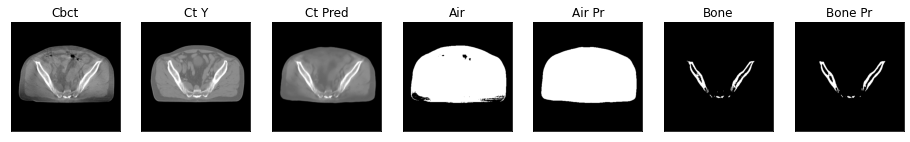

ssim score = 0.8253961801528931
psnr score = 22.395767211914062
snr score = 12.982010841369629
mae error = 0.029086275026202202
air dice score = 0.9714970910867597
bone dice score = 0.9142857142870525


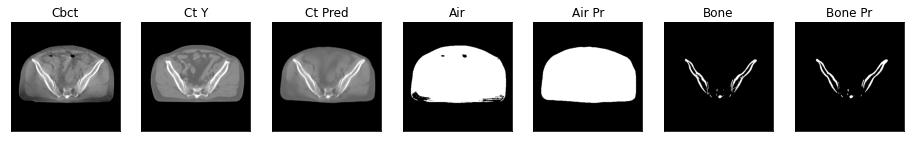

ssim score = 0.8260301351547241
psnr score = 22.517715454101562
snr score = 13.092689514160156
mae error = 0.02894219197332859
air dice score = 0.9716977758707255
bone dice score = 0.9220691971796764


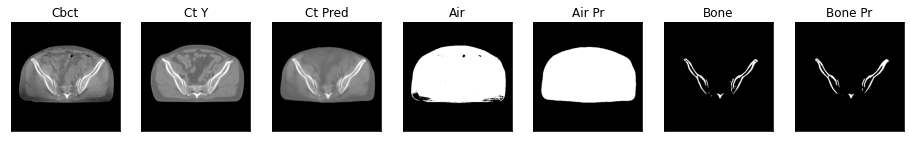

10it [00:22,  2.17s/it]

ssim score = 0.8313130140304565
psnr score = 22.973007202148438
snr score = 13.54724407196045
mae error = 0.02739858627319336
air dice score = 0.9769200585024999
bone dice score = 0.9058149058164485


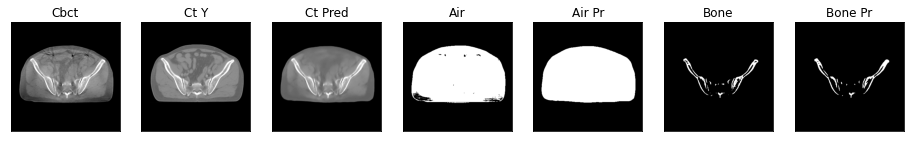

ssim score = 0.886928379535675
psnr score = 24.100677490234375
snr score = 14.534811019897461
mae error = 0.017922287806868553
air dice score = 0.9868260551354096
bone dice score = 0.9576302962145621


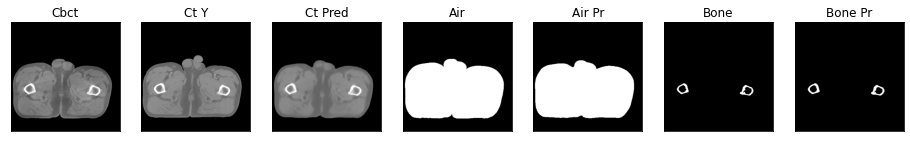

ssim score = 0.8901406526565552
psnr score = 24.461183547973633
snr score = 14.959711074829102
mae error = 0.017511239275336266
air dice score = 0.9869796294202324
bone dice score = 0.9494459833812519


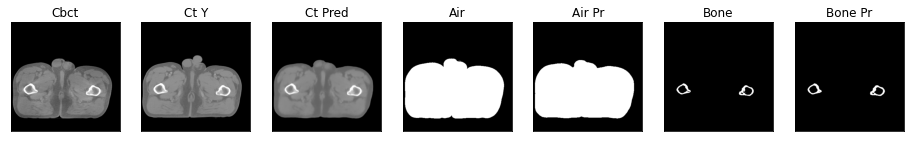

ssim score = 0.8918842673301697
psnr score = 26.36446189880371
snr score = 17.002201080322266
mae error = 0.015807921066880226
air dice score = 0.9912559113847785
bone dice score = 0.9560841720046641


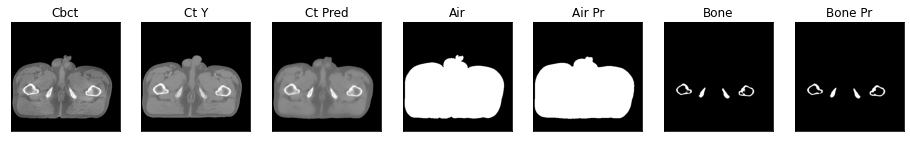

ssim score = 0.8991560339927673
psnr score = 27.09101676940918
snr score = 17.850248336791992
mae error = 0.015177829191088676
air dice score = 0.9914656771799696
bone dice score = 0.9456993918343679


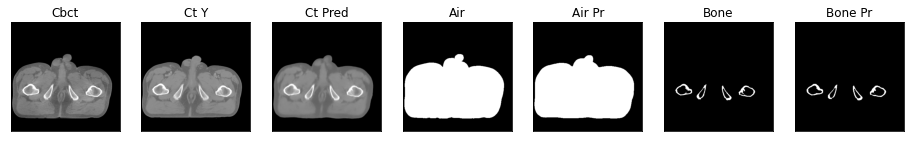

ssim score = 0.8897231817245483
psnr score = 26.36174774169922
snr score = 17.145151138305664
mae error = 0.016533227637410164
air dice score = 0.991166620700531
bone dice score = 0.9341894061010275


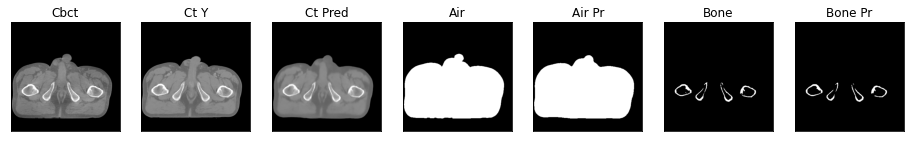

ssim score = 0.8852647542953491
psnr score = 25.76999282836914
snr score = 16.548999786376953
mae error = 0.017057450488209724
air dice score = 0.9913080347678678
bone dice score = 0.9238472772809546


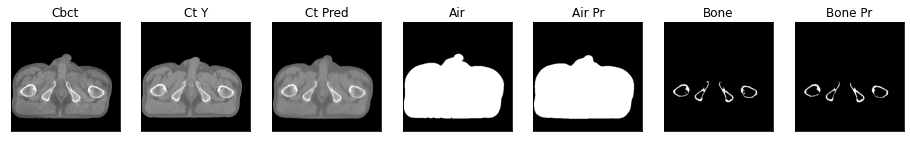

ssim score = 0.8879062533378601
psnr score = 25.33185577392578
snr score = 16.117116928100586
mae error = 0.01757337711751461
air dice score = 0.993400736734859
bone dice score = 0.9127080795795228


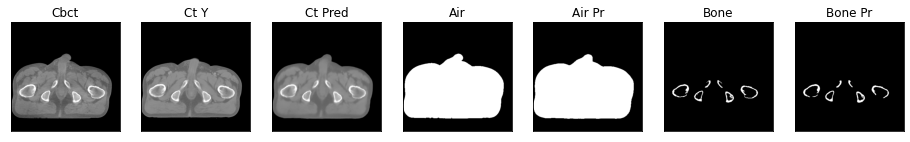

11it [00:24,  2.21s/it]

ssim score = 0.8843743205070496
psnr score = 24.85835075378418
snr score = 15.622057914733887
mae error = 0.01790742017328739
air dice score = 0.9943419588420651
bone dice score = 0.9284578696357619


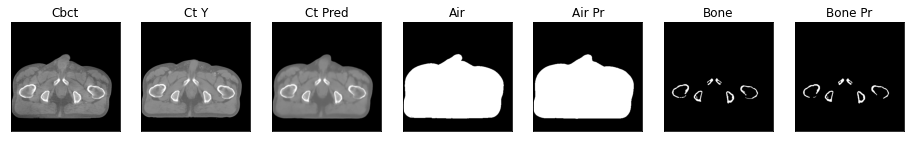

ssim score = 0.8905536532402039
psnr score = 25.239757537841797
snr score = 16.02037239074707
mae error = 0.01704632118344307
air dice score = 0.9945922153052925
bone dice score = 0.9350266887551072


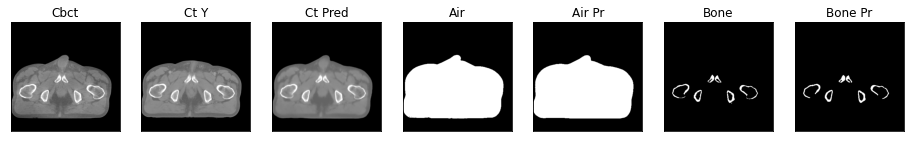

ssim score = 0.8877674341201782
psnr score = 25.335264205932617
snr score = 16.184473037719727
mae error = 0.0169460941106081
air dice score = 0.991571123586628
bone dice score = 0.9294291824324818


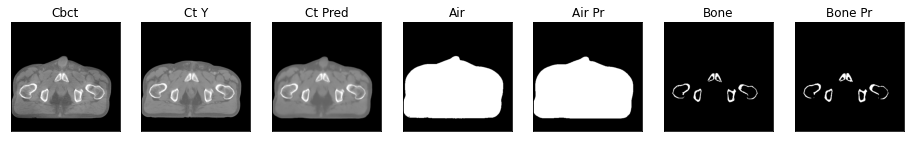

ssim score = 0.8837987780570984
psnr score = 25.414146423339844
snr score = 16.344715118408203
mae error = 0.017379606142640114
air dice score = 0.9902846402144594
bone dice score = 0.9267993874436937


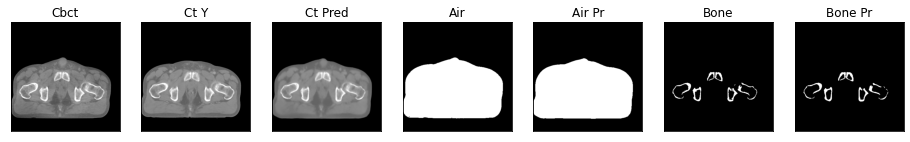

ssim score = 0.885509729385376
psnr score = 25.900638580322266
snr score = 16.881906509399414
mae error = 0.016886578872799873
air dice score = 0.9901898961517971
bone dice score = 0.9080714180329339


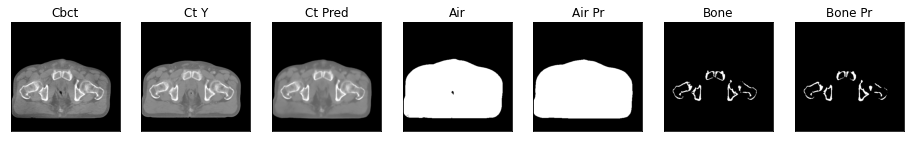

ssim score = 0.8889240622520447
psnr score = 26.07928466796875
snr score = 17.17682456970215
mae error = 0.016549060121178627
air dice score = 0.9906512108564591
bone dice score = 0.8907958477523765


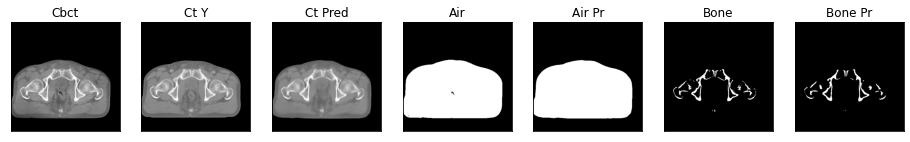

ssim score = 0.8870764970779419
psnr score = 26.028528213500977
snr score = 17.087831497192383
mae error = 0.0164541807025671
air dice score = 0.987653722075349
bone dice score = 0.8790383170566636


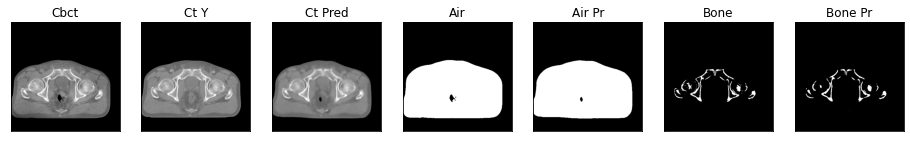

ssim score = 0.8908670544624329
psnr score = 26.943552017211914
snr score = 17.90718650817871
mae error = 0.015287339687347412
air dice score = 0.9823251872193891
bone dice score = 0.8605174353225461


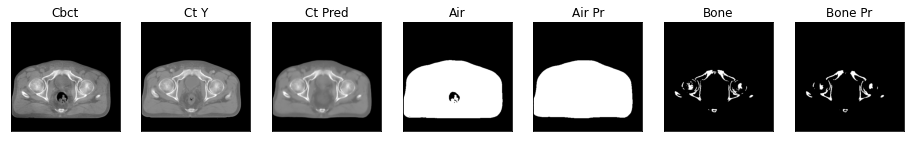

12it [00:26,  2.16s/it]

ssim score = 0.8983285427093506
psnr score = 27.47943878173828
snr score = 18.283313751220703
mae error = 0.01448377687484026
air dice score = 0.9841877903659759
bone dice score = 0.8696257615340361


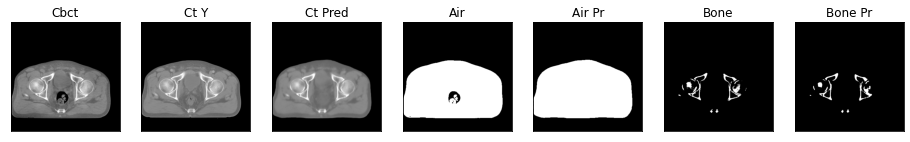

ssim score = 0.8977558612823486
psnr score = 27.400943756103516
snr score = 18.088394165039062
mae error = 0.014355732128024101
air dice score = 0.9809180666923984
bone dice score = 0.8771867190311106


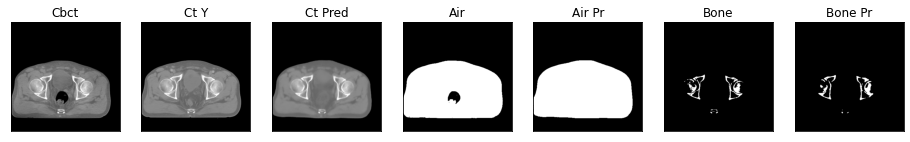

ssim score = 0.8940761089324951
psnr score = 27.351547241210938
snr score = 17.993900299072266
mae error = 0.014370539225637913
air dice score = 0.9809211666900735
bone dice score = 0.9081330260140248


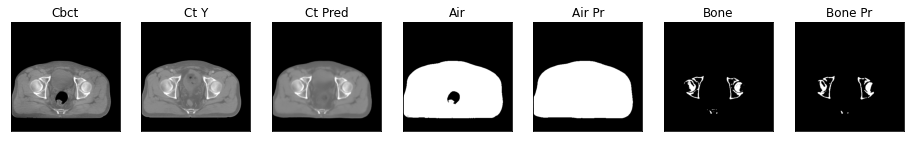

ssim score = 0.8898040652275085
psnr score = 26.59839630126953
snr score = 17.247425079345703
mae error = 0.015892773866653442
air dice score = 0.9828570483014389
bone dice score = 0.9266025641037403


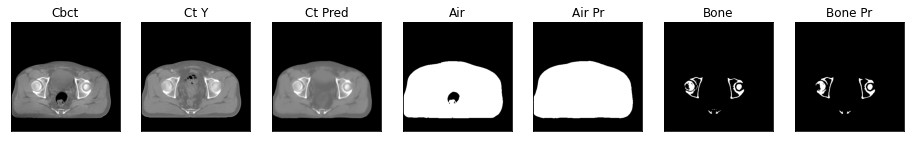

ssim score = 0.884037435054779
psnr score = 25.205123901367188
snr score = 15.884255409240723
mae error = 0.018062449991703033
air dice score = 0.9845639759607121
bone dice score = 0.9400677367112344


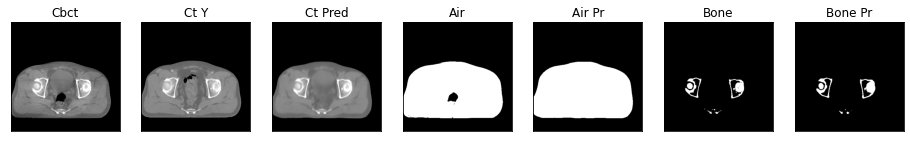

ssim score = 0.8897653818130493
psnr score = 24.983795166015625
snr score = 15.620342254638672
mae error = 0.017840247601270676
air dice score = 0.9901467155718655
bone dice score = 0.9433394618094043


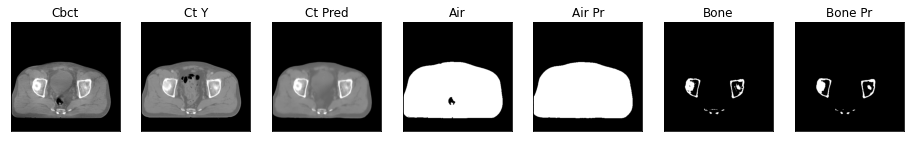

ssim score = 0.886768639087677
psnr score = 24.646427154541016
snr score = 15.192770004272461
mae error = 0.018233371898531914
air dice score = 0.9905731586628054
bone dice score = 0.9201228878663571


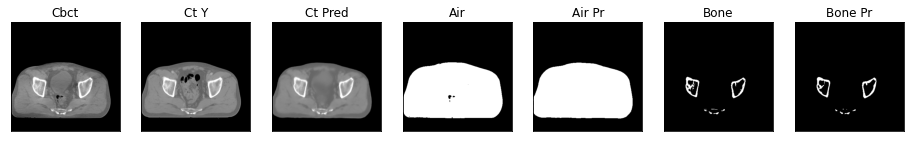

ssim score = 0.8835388422012329
psnr score = 24.503231048583984
snr score = 14.983846664428711
mae error = 0.018589714542031288
air dice score = 0.9890663286861098
bone dice score = 0.942122817344671


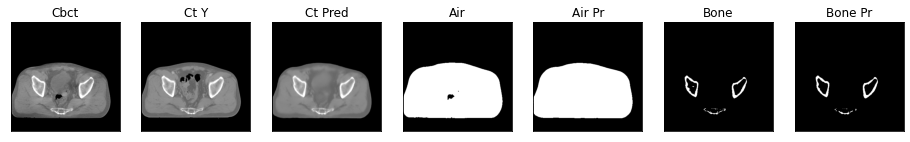

13it [00:28,  2.19s/it]

ssim score = 0.8843429684638977
psnr score = 25.073184967041016
snr score = 15.553498268127441
mae error = 0.017854733392596245
air dice score = 0.9899586432254965
bone dice score = 0.9416595380677218


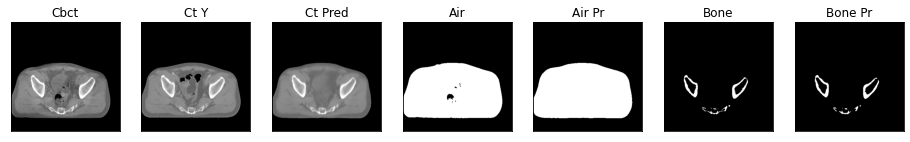

ssim score = 0.882583498954773
psnr score = 25.342601776123047
snr score = 15.89908218383789
mae error = 0.018160836771130562
air dice score = 0.9877519512822817
bone dice score = 0.9398845558223302


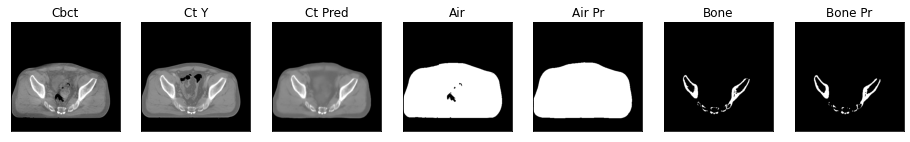

ssim score = 0.8905731439590454
psnr score = 25.529586791992188
snr score = 16.121646881103516
mae error = 0.017285937443375587
air dice score = 0.9858604457260106
bone dice score = 0.9300368227258017


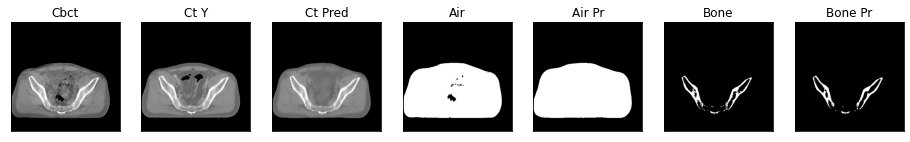

ssim score = 0.892742395401001
psnr score = 25.231124877929688
snr score = 15.761489868164062
mae error = 0.017623886466026306
air dice score = 0.986064855390021
bone dice score = 0.9131534569995341


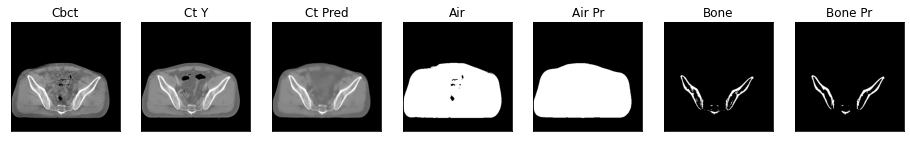

ssim score = 0.8871763348579407
psnr score = 24.955921173095703
snr score = 15.425024032592773
mae error = 0.018263470381498337
air dice score = 0.984949018009811
bone dice score = 0.9059854448253976


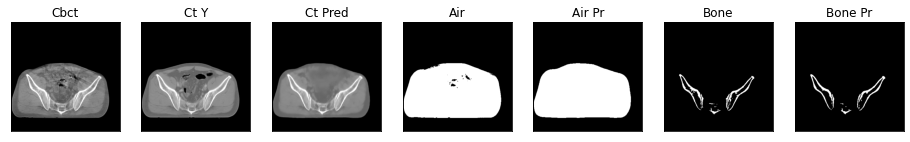

ssim score = 0.8256282210350037
psnr score = 22.817447662353516
snr score = 14.514753341674805
mae error = 0.027293870225548744
air dice score = 0.9880146286707535
bone dice score = 0.9766282330951502


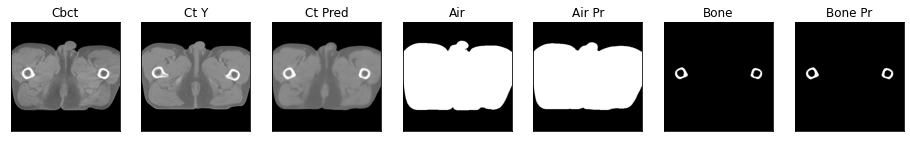

ssim score = 0.8216469883918762
psnr score = 22.65937614440918
snr score = 14.460972785949707
mae error = 0.02873058058321476
air dice score = 0.9878174289749002
bone dice score = 0.9657320872283848


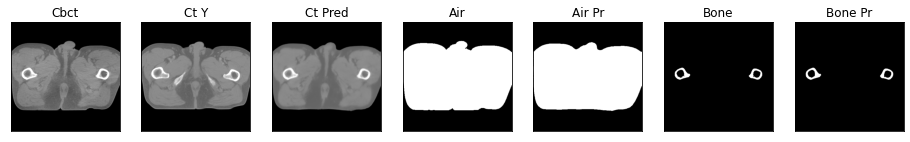

ssim score = 0.8109940886497498
psnr score = 22.10797882080078
snr score = 14.037532806396484
mae error = 0.031552646309137344
air dice score = 0.9878535257022812
bone dice score = 0.9393939393953307


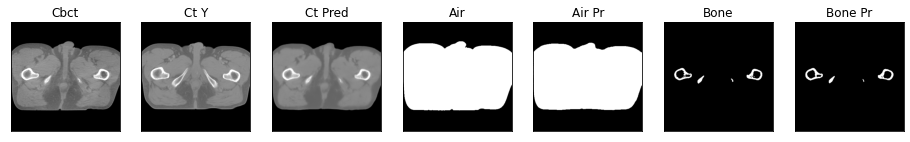

14it [00:31,  2.22s/it]

ssim score = 0.8004417419433594
psnr score = 21.619678497314453
snr score = 13.581520080566406
mae error = 0.03256461024284363
air dice score = 0.9893338556598293
bone dice score = 0.9491873396073707


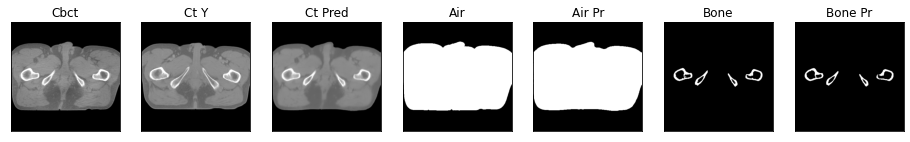

ssim score = 0.7906317114830017
psnr score = 21.436195373535156
snr score = 13.428276062011719
mae error = 0.033655136823654175
air dice score = 0.9904776541101007
bone dice score = 0.9320356318058061


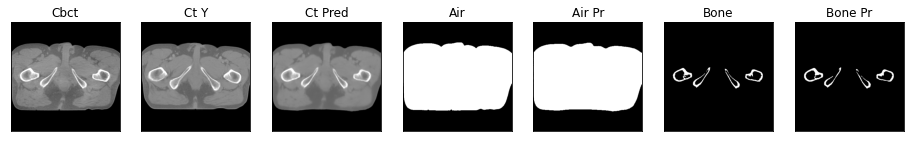

ssim score = 0.7839756608009338
psnr score = 21.50506019592285
snr score = 13.531558990478516
mae error = 0.03401409462094307
air dice score = 0.9913621027715512
bone dice score = 0.9260439910754535


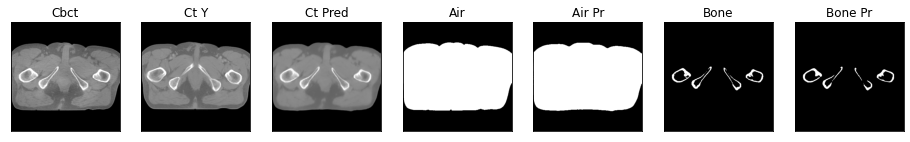

ssim score = 0.7785385251045227
psnr score = 21.340234756469727
snr score = 13.387042045593262
mae error = 0.03495262190699577
air dice score = 0.9926957663583221
bone dice score = 0.9222520107249577


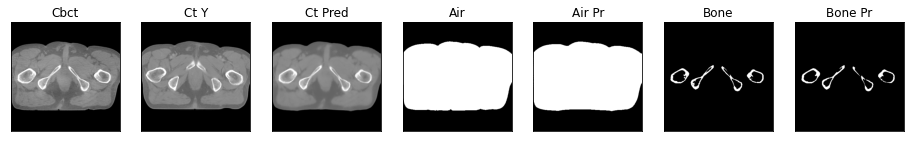

ssim score = 0.7725991606712341
psnr score = 21.021434783935547
snr score = 13.107315063476562
mae error = 0.036341432482004166
air dice score = 0.9924908617407697
bone dice score = 0.9126862553974002


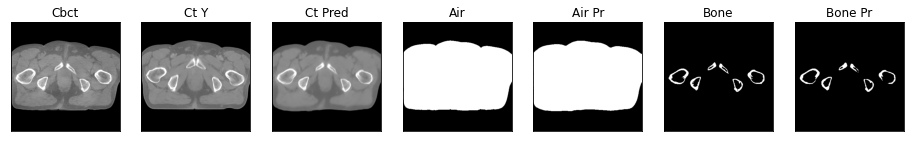

ssim score = 0.7671703100204468
psnr score = 21.00868034362793
snr score = 13.143241882324219
mae error = 0.03674815967679024
air dice score = 0.9921430569803272
bone dice score = 0.926010474017376


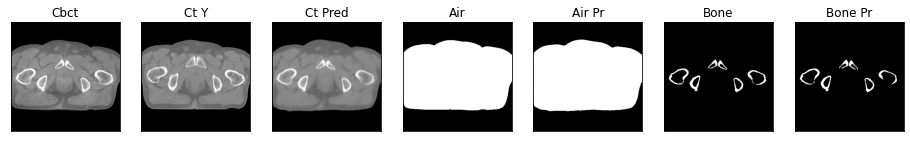

ssim score = 0.7589767575263977
psnr score = 20.889318466186523
snr score = 13.046492576599121
mae error = 0.03801403567194939
air dice score = 0.9932896861718602
bone dice score = 0.9268983268992678


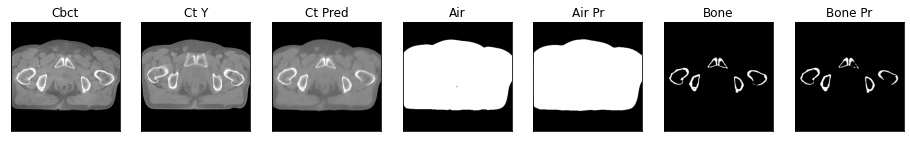

ssim score = 0.7455676198005676
psnr score = 20.61313247680664
snr score = 12.813082695007324
mae error = 0.04064048454165459
air dice score = 0.9923032753130645
bone dice score = 0.9151470945791982


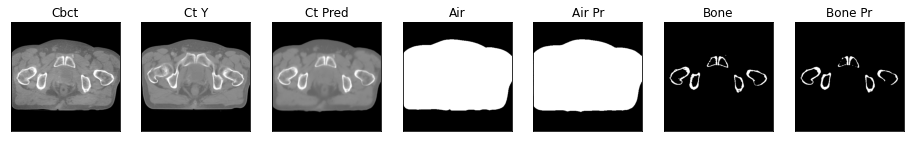

15it [00:33,  2.18s/it]

ssim score = 0.7499366402626038
psnr score = 20.846567153930664
snr score = 13.104857444763184
mae error = 0.03951418399810791
air dice score = 0.993615207520257
bone dice score = 0.9188240456349405


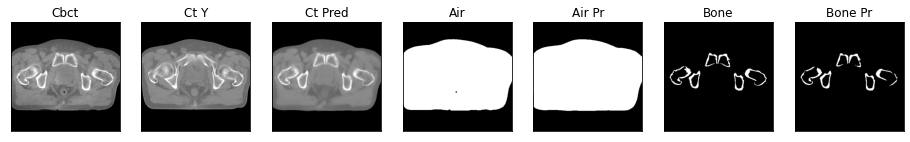

ssim score = 0.7431079745292664
psnr score = 20.602378845214844
snr score = 12.785297393798828
mae error = 0.041606657207012177
air dice score = 0.993301036137321
bone dice score = 0.8894549159461085


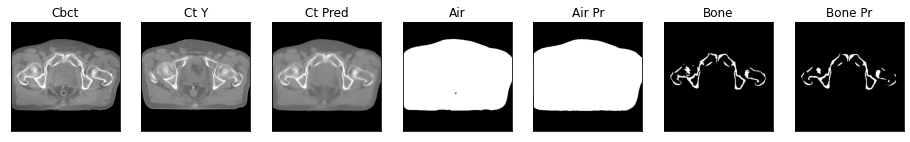

ssim score = 0.7476036548614502
psnr score = 20.591238021850586
snr score = 12.666936874389648
mae error = 0.04200978949666023
air dice score = 0.9931443738083826
bone dice score = 0.8531050134118723


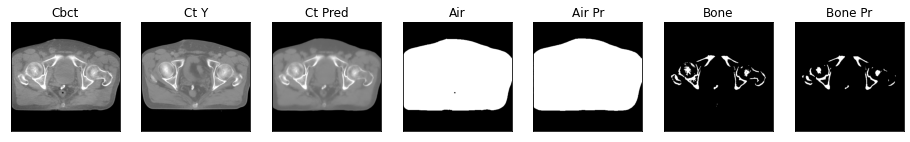

ssim score = 0.7677570581436157
psnr score = 21.077434539794922
snr score = 13.030044555664062
mae error = 0.03952312469482422
air dice score = 0.9940107249808517
bone dice score = 0.8286450283376748


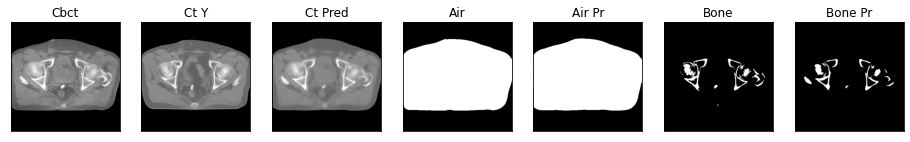

ssim score = 0.7663866281509399
psnr score = 21.008655548095703
snr score = 12.848836898803711
mae error = 0.03894640505313873
air dice score = 0.9935200158218682
bone dice score = 0.8914203612490618


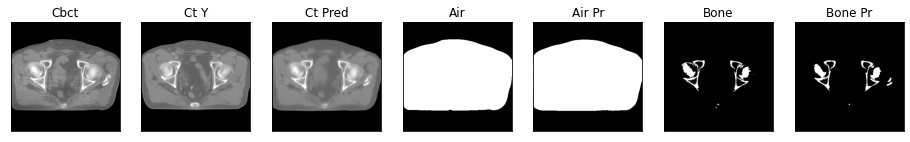

ssim score = 0.7656816244125366
psnr score = 21.316322326660156
snr score = 13.105857849121094
mae error = 0.03616439923644066
air dice score = 0.9925033279618904
bone dice score = 0.9272374732122948


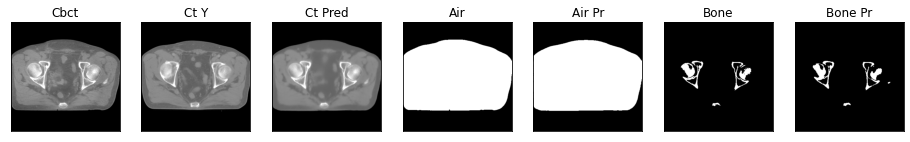

ssim score = 0.7652831673622131
psnr score = 21.15537452697754
snr score = 12.977062225341797
mae error = 0.03728697821497917
air dice score = 0.9935334981197981
bone dice score = 0.9209464616735258


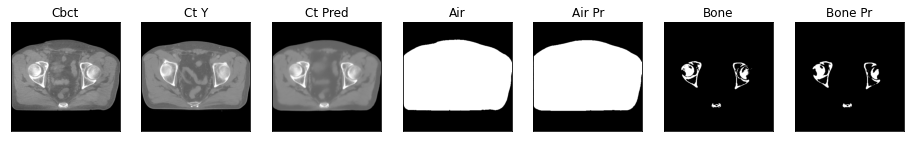

ssim score = 0.7671589851379395
psnr score = 21.00092315673828
snr score = 12.836091995239258
mae error = 0.038060255348682404
air dice score = 0.9935218666446841
bone dice score = 0.9112652475494945


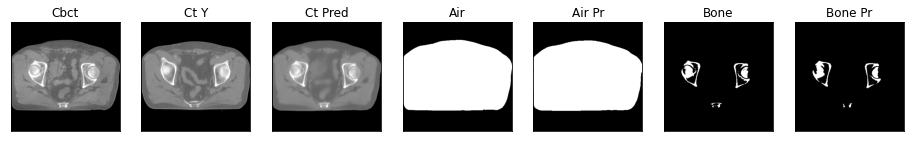

16it [00:35,  2.21s/it]

ssim score = 0.7740293145179749
psnr score = 20.91497039794922
snr score = 12.608643531799316
mae error = 0.03834684565663338
air dice score = 0.9921042172141162
bone dice score = 0.9326900447171959


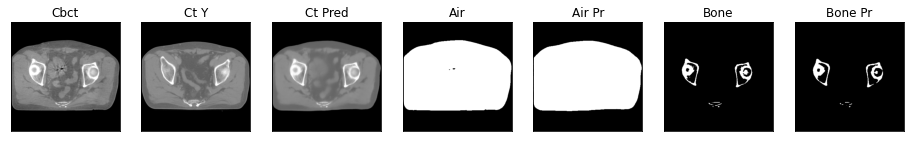

ssim score = 0.7843228578567505
psnr score = 21.042247772216797
snr score = 12.67661190032959
mae error = 0.03705403581261635
air dice score = 0.9923651383036468
bone dice score = 0.9272377814397689


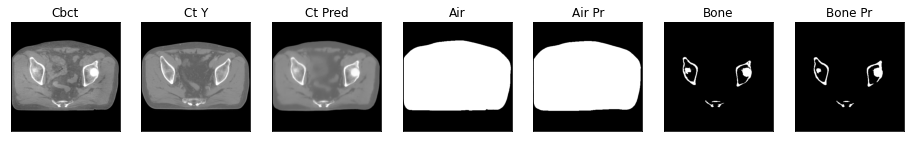

ssim score = 0.7827646136283875
psnr score = 21.395919799804688
snr score = 13.055933952331543
mae error = 0.035026274621486664
air dice score = 0.9913009023287699
bone dice score = 0.911730545878596


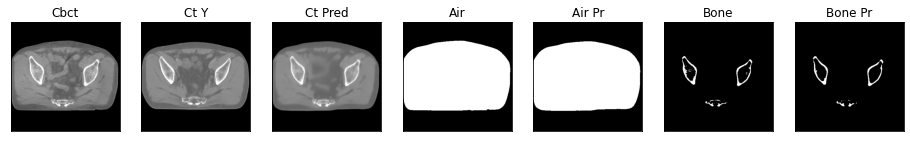

ssim score = 0.7815802097320557
psnr score = 21.419574737548828
snr score = 13.152402877807617
mae error = 0.03507319092750549
air dice score = 0.9918983435005956
bone dice score = 0.9242124212434886


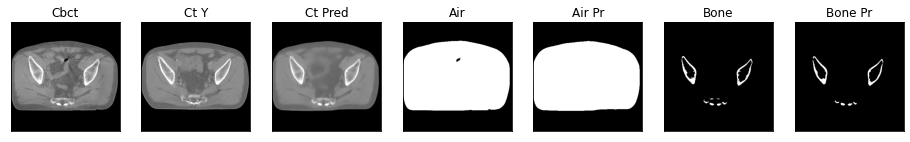

ssim score = 0.7732855677604675
psnr score = 21.1184139251709
snr score = 12.98047161102295
mae error = 0.03706299141049385
air dice score = 0.9905897190255081
bone dice score = 0.9360158311356198


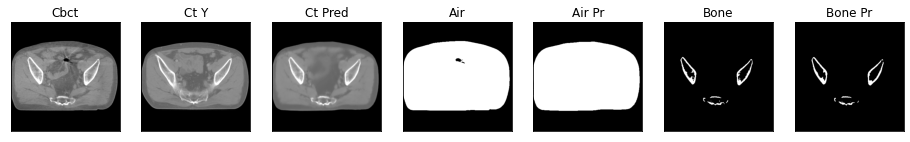

ssim score = 0.7632532715797424
psnr score = 20.956174850463867
snr score = 12.852191925048828
mae error = 0.03827188163995743
air dice score = 0.990046263844111
bone dice score = 0.9380345086280865


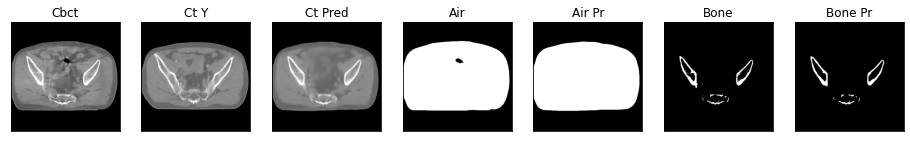

ssim score = 0.7515077590942383
psnr score = 20.71174430847168
snr score = 12.577972412109375
mae error = 0.03985513746738434
air dice score = 0.9907167728393759
bone dice score = 0.9141096734452975


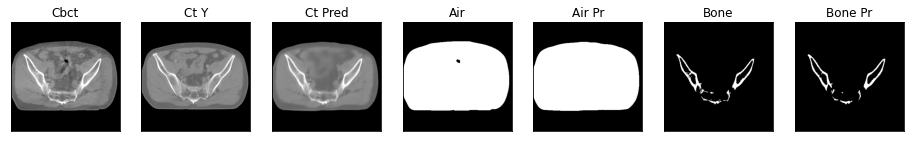

ssim score = 0.7581902742385864
psnr score = 21.138113021850586
snr score = 12.94096565246582
mae error = 0.03746731951832771
air dice score = 0.990187881172542
bone dice score = 0.9194639777110327


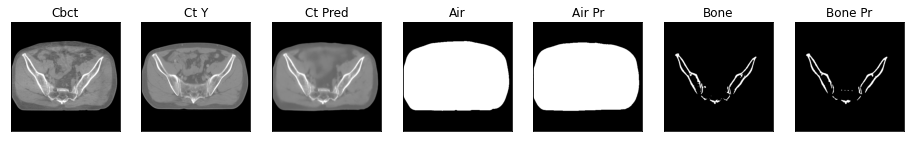

17it [00:37,  2.17s/it]

ssim score = 0.8562077879905701
psnr score = 23.40047836303711
snr score = 14.877870559692383
mae error = 0.023593876510858536
air dice score = 0.9868163840523808
bone dice score = 0.9047793668267353


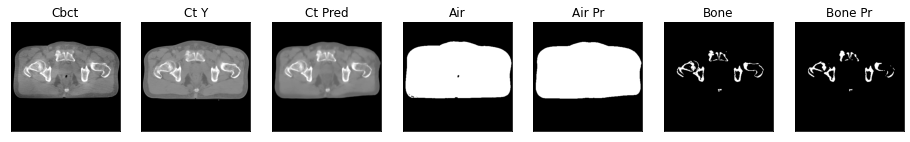

ssim score = 0.8632504343986511
psnr score = 24.134498596191406
snr score = 15.651901245117188
mae error = 0.021801970899105072
air dice score = 0.9902163886830758
bone dice score = 0.8938008130094791


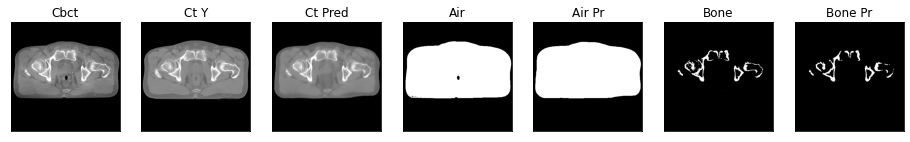

ssim score = 0.8565638065338135
psnr score = 23.440645217895508
snr score = 14.965835571289062
mae error = 0.023737682029604912
air dice score = 0.987256548401569
bone dice score = 0.8701454691062306


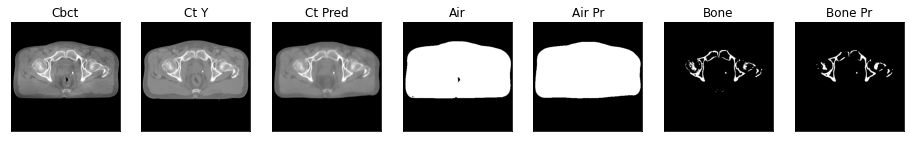

ssim score = 0.8636119961738586
psnr score = 23.88321304321289
snr score = 15.349985122680664
mae error = 0.02216953970491886
air dice score = 0.9891838890873657
bone dice score = 0.8712795726294673


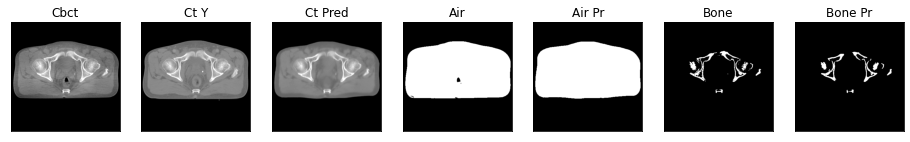

ssim score = 0.8689274787902832
psnr score = 23.94139862060547
snr score = 15.252543449401855
mae error = 0.02100331522524357
air dice score = 0.9895415669355041
bone dice score = 0.8868629502333454


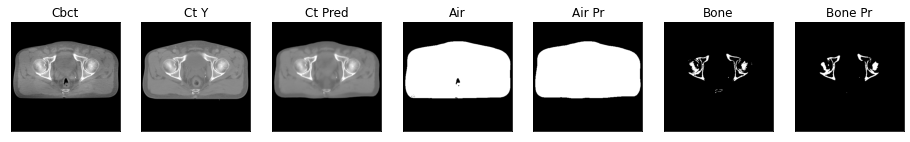

ssim score = 0.8820102214813232
psnr score = 25.25083351135254
snr score = 16.541175842285156
mae error = 0.018194789066910744
air dice score = 0.9906698400869973
bone dice score = 0.9112326461939246


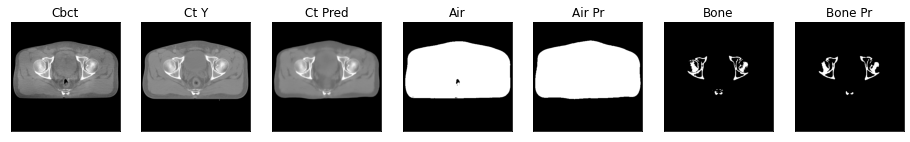

ssim score = 0.8834653496742249
psnr score = 25.293302536010742
snr score = 16.568016052246094
mae error = 0.017768619582057
air dice score = 0.9908314311670338
bone dice score = 0.922330097088426


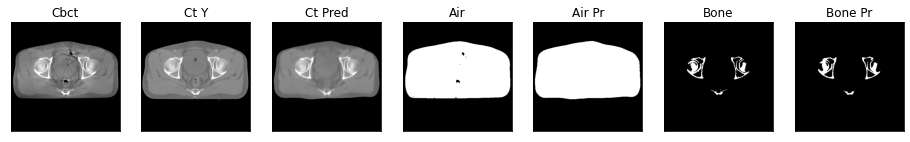

ssim score = 0.8766908645629883
psnr score = 24.317352294921875
snr score = 15.60142993927002
mae error = 0.01958746835589409
air dice score = 0.9897263429466586
bone dice score = 0.9127071823216477


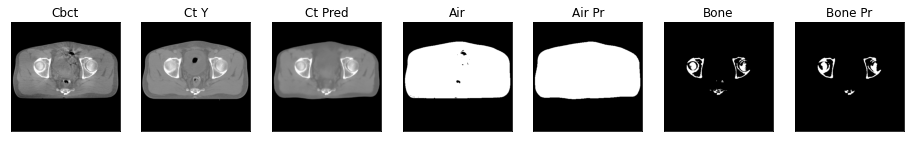

18it [00:39,  2.20s/it]

ssim score = 0.8701342344284058
psnr score = 23.77123260498047
snr score = 15.111093521118164
mae error = 0.021522188559174538
air dice score = 0.9869560180716014
bone dice score = 0.9278296306043403


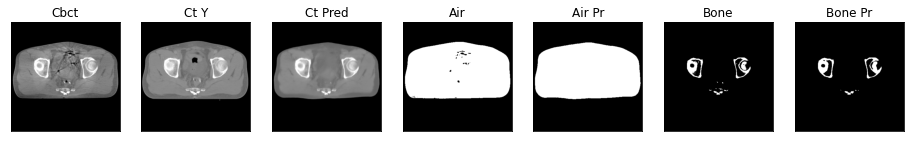

ssim score = 0.8706604838371277
psnr score = 23.45391082763672
snr score = 14.771838188171387
mae error = 0.02208612486720085
air dice score = 0.9864352188792127
bone dice score = 0.9232053422381301


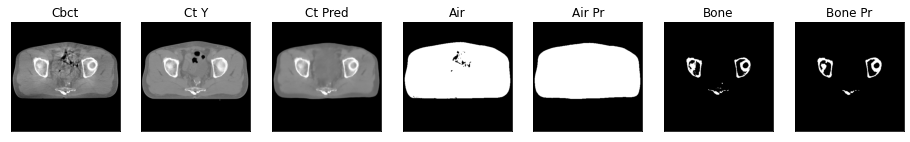

ssim score = 0.8686588406562805
psnr score = 22.92568016052246
snr score = 14.172835350036621
mae error = 0.022659583017230034
air dice score = 0.984655408773691
bone dice score = 0.913077772520696


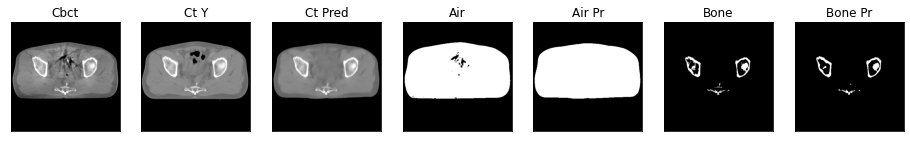

ssim score = 0.8692016005516052
psnr score = 23.110702514648438
snr score = 14.313962936401367
mae error = 0.022468561306595802
air dice score = 0.9861559328375769
bone dice score = 0.9161676646720531


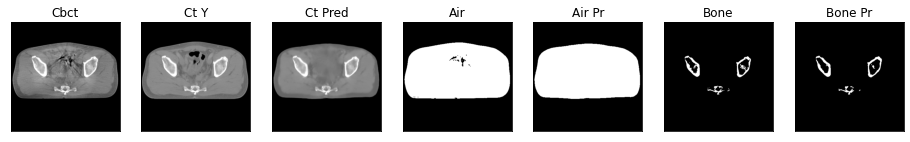

ssim score = 0.867324709892273
psnr score = 23.34299087524414
snr score = 14.545154571533203
mae error = 0.022221188992261887
air dice score = 0.9849501728696477
bone dice score = 0.9262584161602074


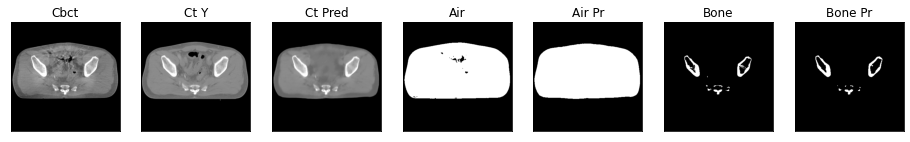

ssim score = 0.8714973330497742
psnr score = 23.97425079345703
snr score = 15.189772605895996
mae error = 0.020353399217128754
air dice score = 0.9828855080545851
bone dice score = 0.9371480748754049


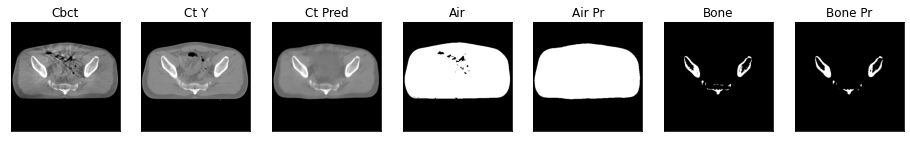

ssim score = 0.8688239455223083
psnr score = 24.213123321533203
snr score = 15.483848571777344
mae error = 0.020508553832769394
air dice score = 0.9813706654908654
bone dice score = 0.9414886894990334


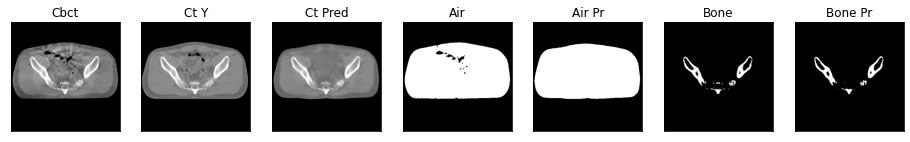

ssim score = 0.8705623149871826
psnr score = 24.02871322631836
snr score = 15.318811416625977
mae error = 0.020576918497681618
air dice score = 0.9828699360677454
bone dice score = 0.9304897314385139


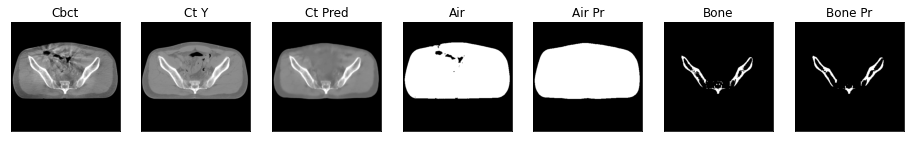

19it [00:41,  2.16s/it]

ssim score = 0.8714439272880554
psnr score = 23.815624237060547
snr score = 15.050979614257812
mae error = 0.02138618566095829
air dice score = 0.9860185053829653
bone dice score = 0.9168597914264649


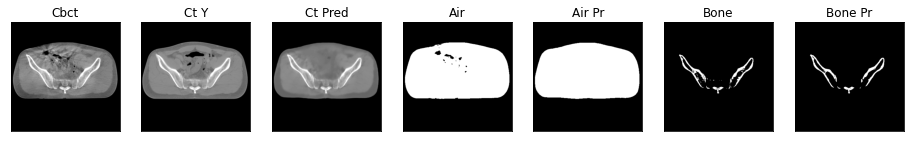

ssim score = 0.8714380264282227
psnr score = 23.763431549072266
snr score = 14.96243953704834
mae error = 0.02160806395113468
air dice score = 0.9885782609379761
bone dice score = 0.89212656365133


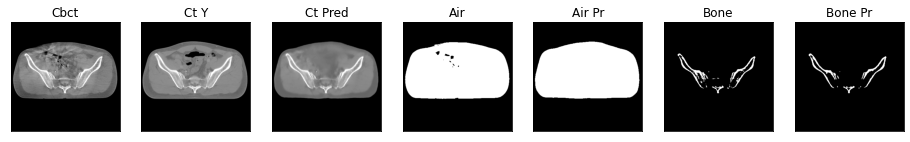

ssim score = 0.8724010586738586
psnr score = 23.517000198364258
snr score = 14.716076850891113
mae error = 0.022117892280220985
air dice score = 0.9879576943082862
bone dice score = 0.8863757317737311


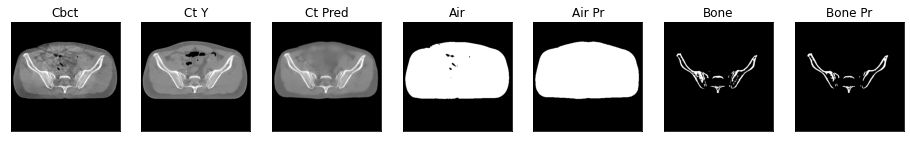

ssim score = 0.8725882768630981
psnr score = 23.93634796142578
snr score = 15.134001731872559
mae error = 0.021754072979092598
air dice score = 0.9844689418235523
bone dice score = 0.89321169841839


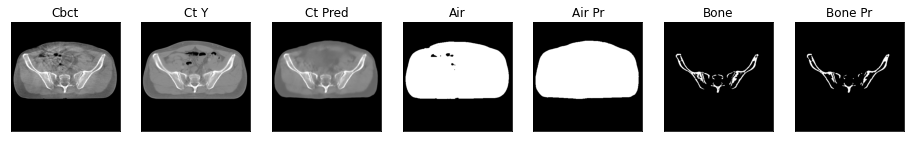

ssim score = 0.8675311207771301
psnr score = 23.623722076416016
snr score = 14.82641315460205
mae error = 0.022782953456044197
air dice score = 0.9821359069065633
bone dice score = 0.8877717391319596


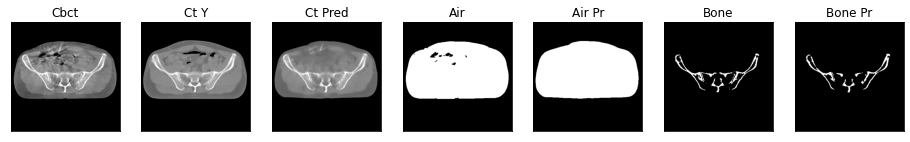

ssim score = 0.8647951483726501
psnr score = 23.444229125976562
snr score = 14.62964916229248
mae error = 0.023293936625123024
air dice score = 0.9777089635027353
bone dice score = 0.8982360922673238


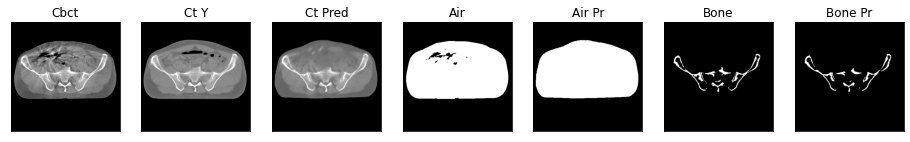

ssim score = 0.8568127751350403
psnr score = 22.518821716308594
snr score = 13.68561840057373
mae error = 0.02623685635626316
air dice score = 0.9755878268269187
bone dice score = 0.8818713450307749


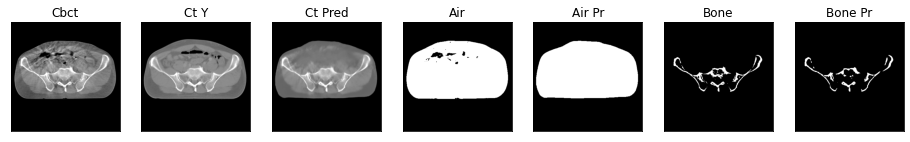

ssim score = 0.8470224142074585
psnr score = 21.926265716552734
snr score = 13.047123908996582
mae error = 0.028130928054451942
air dice score = 0.9765853894767617
bone dice score = 0.8597584233965702


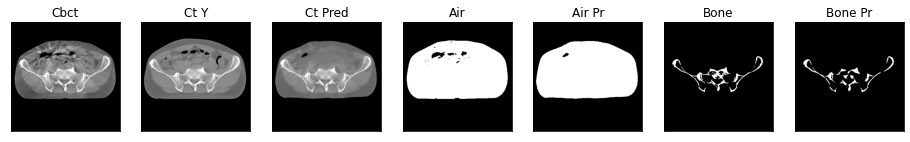

20it [00:44,  2.19s/it]

ssim score = 0.8437591791152954
psnr score = 22.270977020263672
snr score = 13.33803939819336
mae error = 0.027421249076724052
air dice score = 0.9761005475441585
bone dice score = 0.8907870652850421


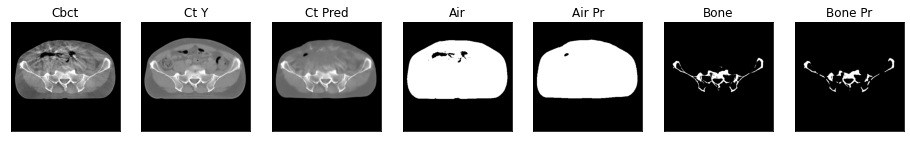

ssim score = 0.840421199798584
psnr score = 22.04500961303711
snr score = 13.142532348632812
mae error = 0.02872682549059391
air dice score = 0.9764609534003288
bone dice score = 0.9023377239835962


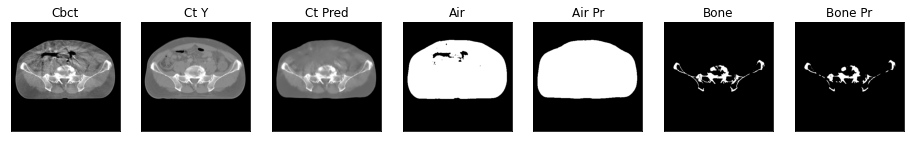

ssim score = 0.8337477445602417
psnr score = 21.246845245361328
snr score = 12.289142608642578
mae error = 0.03131173923611641
air dice score = 0.9741439780754195
bone dice score = 0.8755853689422151


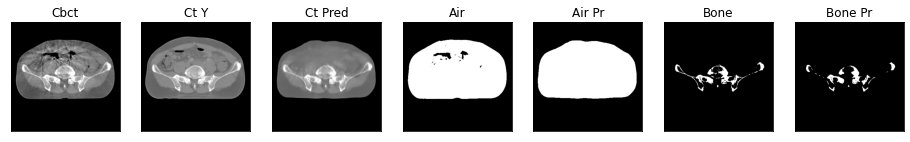

ssim score = 0.8419797420501709
psnr score = 21.93716812133789
snr score = 12.831934928894043
mae error = 0.02861134149134159
air dice score = 0.9774908079993009
bone dice score = 0.9006397702062849


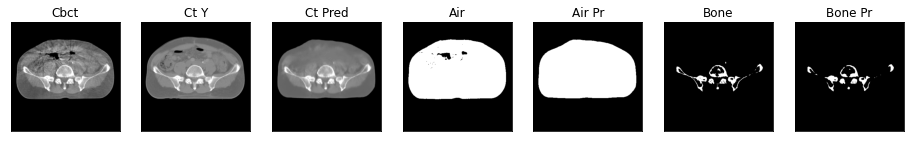

ssim score = 0.8870223760604858
psnr score = 26.203269958496094
snr score = 16.58418083190918
mae error = 0.01538898516446352
air dice score = 0.9877167900476899
bone dice score = 0.9522539343837756


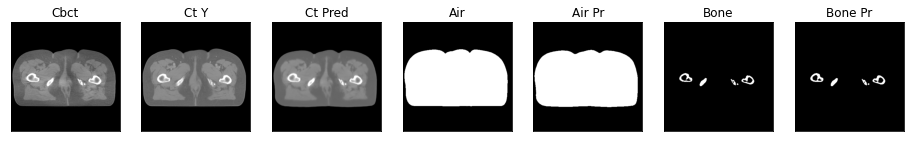

ssim score = 0.8866251707077026
psnr score = 26.210987091064453
snr score = 16.71291160583496
mae error = 0.015544237568974495
air dice score = 0.9888564270687059
bone dice score = 0.9548650487649157


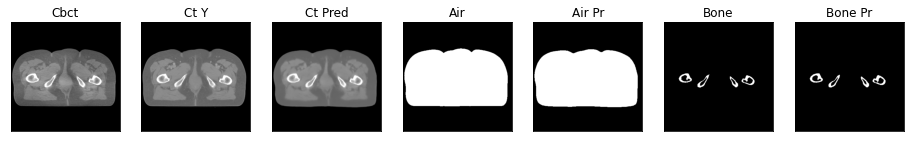

ssim score = 0.8841419816017151
psnr score = 26.33310317993164
snr score = 16.91794204711914
mae error = 0.015911782160401344
air dice score = 0.9893634308844681
bone dice score = 0.9447194719483349


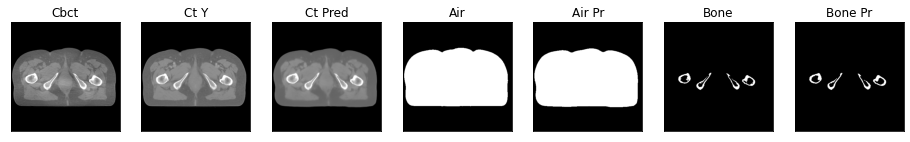

ssim score = 0.8812001347541809
psnr score = 26.178573608398438
snr score = 16.826860427856445
mae error = 0.016011778265237808
air dice score = 0.9904065447375848
bone dice score = 0.9394556563610543


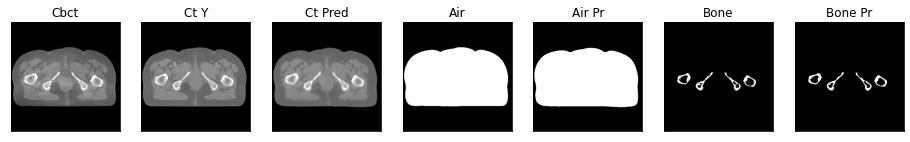

21it [00:46,  2.21s/it]

ssim score = 0.8837656378746033
psnr score = 26.184837341308594
snr score = 16.86158561706543
mae error = 0.01590397208929062
air dice score = 0.9906161408238233
bone dice score = 0.945869947276874


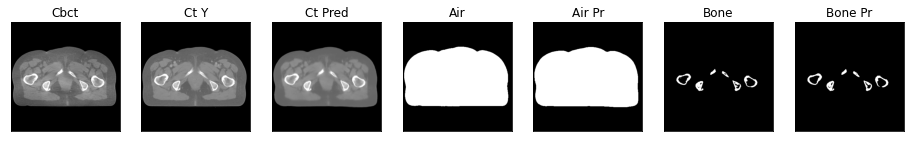

ssim score = 0.8841040730476379
psnr score = 26.25286102294922
snr score = 16.95256233215332
mae error = 0.015717769041657448
air dice score = 0.9919020054961177
bone dice score = 0.9402550091085564


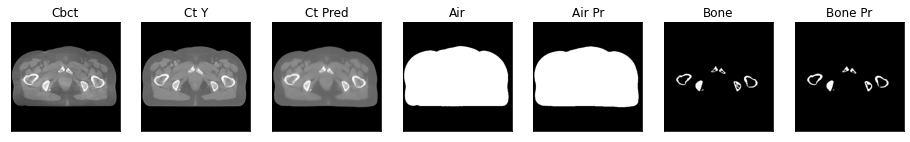

ssim score = 0.8811296224594116
psnr score = 26.163074493408203
snr score = 16.89410400390625
mae error = 0.015947729349136353
air dice score = 0.9917930536406074
bone dice score = 0.9369882520481134


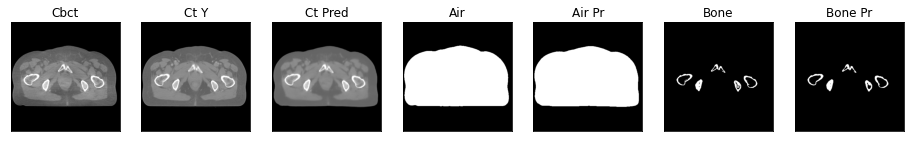

ssim score = 0.8842547535896301
psnr score = 26.217058181762695
snr score = 16.99645233154297
mae error = 0.016413386911153793
air dice score = 0.9908534809204844
bone dice score = 0.940991620112762


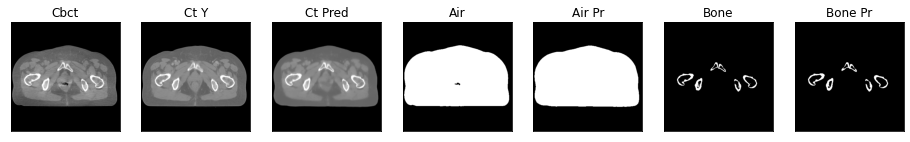

ssim score = 0.8839194774627686
psnr score = 25.90766716003418
snr score = 16.729801177978516
mae error = 0.016840223222970963
air dice score = 0.9891496157155645
bone dice score = 0.9366880447305265


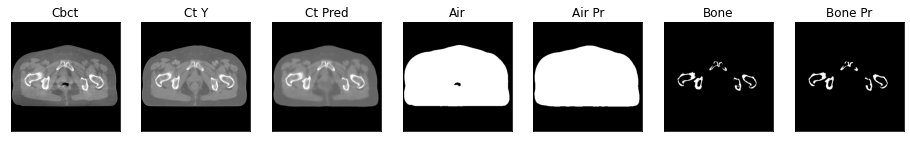

ssim score = 0.8780173659324646
psnr score = 25.76413345336914
snr score = 16.673973083496094
mae error = 0.017348432913422585
air dice score = 0.9870697505008289
bone dice score = 0.9269542930382036


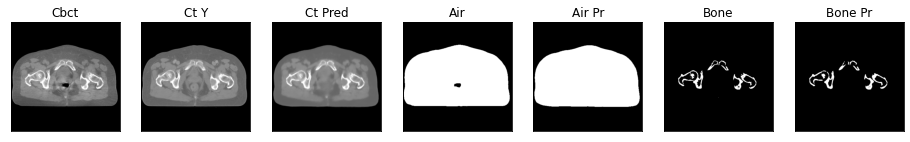

ssim score = 0.8792446851730347
psnr score = 25.90122413635254
snr score = 16.92433738708496
mae error = 0.01725814864039421
air dice score = 0.987828892392885
bone dice score = 0.9285380663249819


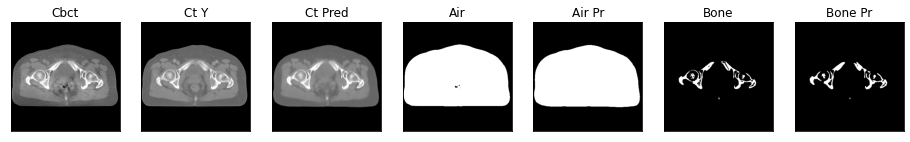

ssim score = 0.8828266263008118
psnr score = 26.364404678344727
snr score = 17.25896644592285
mae error = 0.0163069199770689
air dice score = 0.9856086899696594
bone dice score = 0.9030691867538916


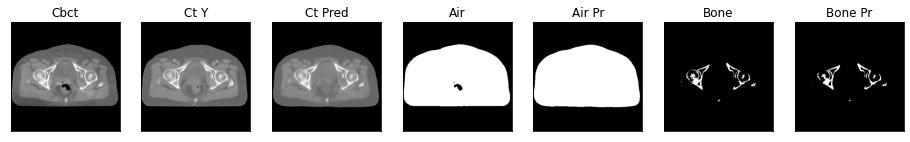

22it [00:48,  2.17s/it]

ssim score = 0.884918212890625
psnr score = 26.357696533203125
snr score = 17.142833709716797
mae error = 0.01642639748752117
air dice score = 0.9863031672559053
bone dice score = 0.8931888544912309


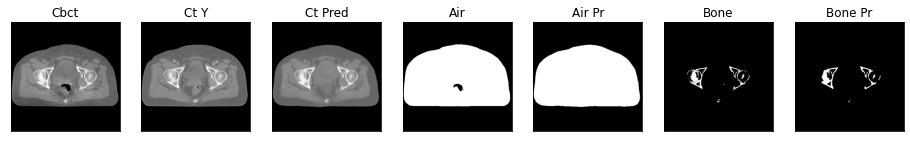

ssim score = 0.8848410844802856
psnr score = 26.287147521972656
snr score = 17.04515838623047
mae error = 0.01700397953391075
air dice score = 0.985981579099819
bone dice score = 0.9133722928856416


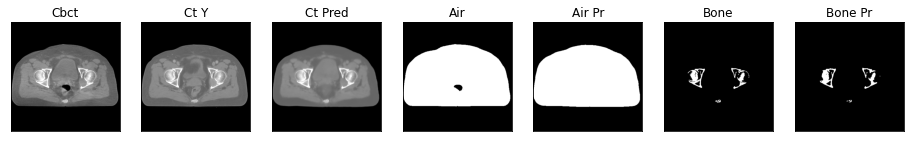

ssim score = 0.8852494359016418
psnr score = 26.0476131439209
snr score = 16.79762077331543
mae error = 0.017653310671448708
air dice score = 0.9876594704215718
bone dice score = 0.9290490947654697


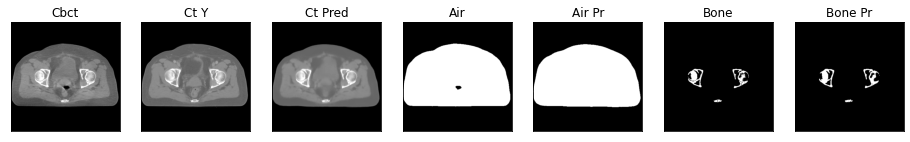

ssim score = 0.8834173679351807
psnr score = 26.271703720092773
snr score = 17.055938720703125
mae error = 0.01651804707944393
air dice score = 0.9886299561043584
bone dice score = 0.9360786724041783


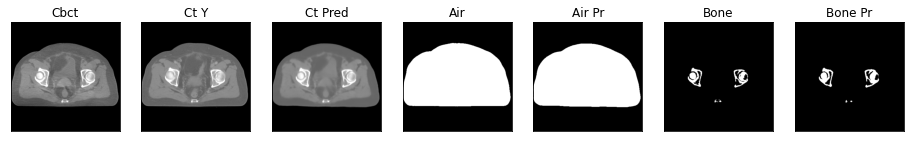

ssim score = 0.883374035358429
psnr score = 26.4919490814209
snr score = 17.32767677307129
mae error = 0.01645166613161564
air dice score = 0.9910574795523854
bone dice score = 0.9478862413536067


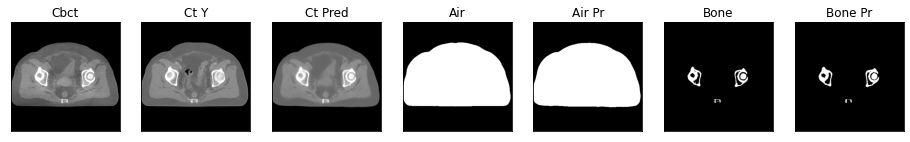

ssim score = 0.8710978031158447
psnr score = 25.399396896362305
snr score = 16.272682189941406
mae error = 0.018160825595259666
air dice score = 0.9905254816155137
bone dice score = 0.9438430311240893


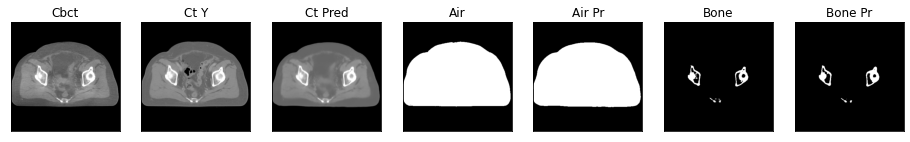

ssim score = 0.8553010821342468
psnr score = 24.025745391845703
snr score = 14.826595306396484
mae error = 0.0207537654787302
air dice score = 0.9882223475904998
bone dice score = 0.9430786268008178


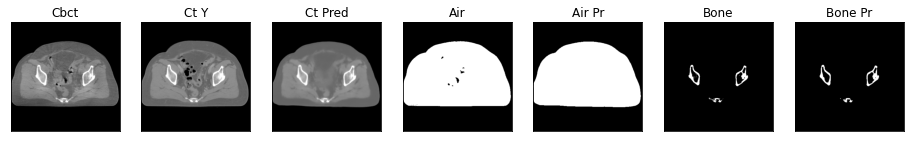

ssim score = 0.8533161282539368
psnr score = 23.963956832885742
snr score = 14.74681282043457
mae error = 0.021237069740891457
air dice score = 0.9865586371663124
bone dice score = 0.9556433904269731


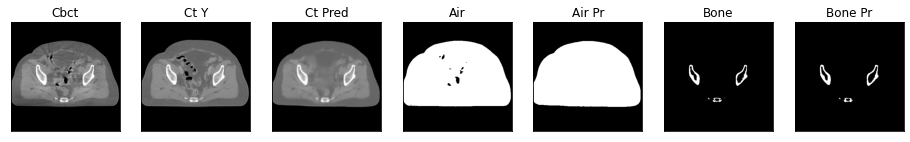

23it [00:50,  2.19s/it]

ssim score = 0.8517941832542419
psnr score = 24.034250259399414
snr score = 14.8820219039917
mae error = 0.021359562873840332
air dice score = 0.9849919980218389
bone dice score = 0.9510696886263277


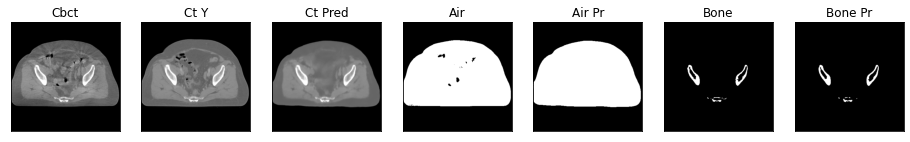

ssim score = 0.84971022605896
psnr score = 23.65582275390625
snr score = 14.558688163757324
mae error = 0.022362232208251953
air dice score = 0.9842574979716893
bone dice score = 0.9530659953254259


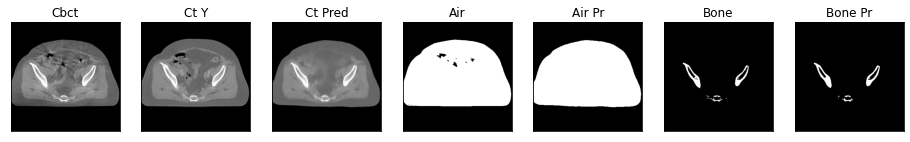

ssim score = 0.8481943011283875
psnr score = 23.427757263183594
snr score = 14.395054817199707
mae error = 0.023208074271678925
air dice score = 0.9853154643351549
bone dice score = 0.9465695203408232


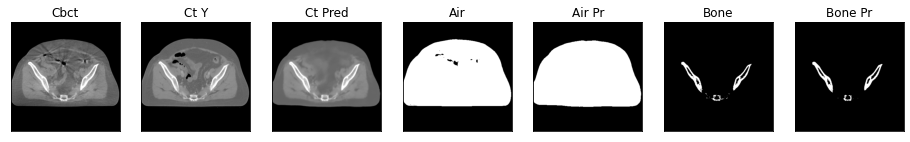

ssim score = 0.8474012613296509
psnr score = 23.26551628112793
snr score = 14.305668830871582
mae error = 0.024166591465473175
air dice score = 0.9848534671937073
bone dice score = 0.9274700171341024


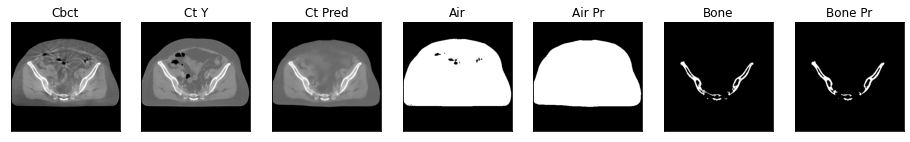

ssim score = 0.8464217185974121
psnr score = 23.620967864990234
snr score = 14.656829833984375
mae error = 0.023570680990815163
air dice score = 0.9847546165363602
bone dice score = 0.9153515064574556


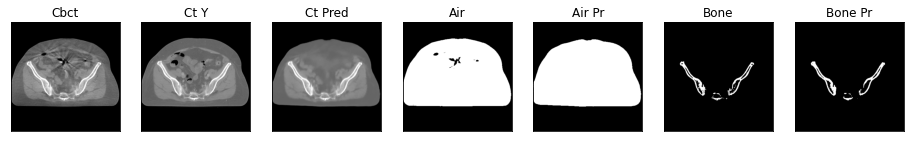

ssim score = 0.8431350588798523
psnr score = 23.480119705200195
snr score = 14.493806838989258
mae error = 0.023947739973664284
air dice score = 0.9868683006579121
bone dice score = 0.9128118867407792


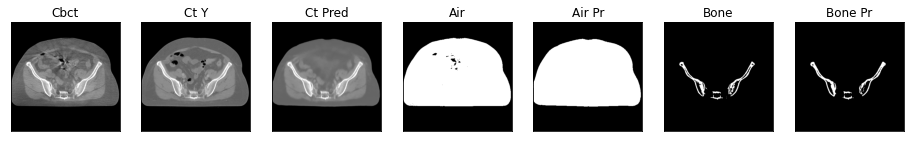

ssim score = 0.8491640090942383
psnr score = 24.304889678955078
snr score = 15.33021354675293
mae error = 0.022236235439777374
air dice score = 0.991554252199419
bone dice score = 0.9120684567732065


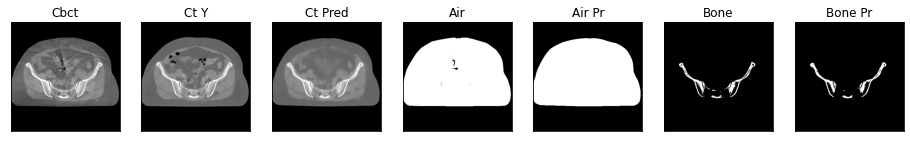

24it [00:52,  2.19s/it]


In [34]:
test_epoch(model, testloader, device, True, os.path.join("eval-gan", wandb.run.name))

In [35]:
discriminator = Model(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [36]:
discriminator.load_state_dict(checkpoint["dicriminator"])

<All keys matched successfully>

In [37]:
# score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_mask_test, score_acc_test 
eval_epoch(model, discriminator, testloader, device)

24it [00:05,  4.27it/s]


(0.8569207812349001,
 24.096325238545734,
 15.110895474751791,
 0.02293694387966146,
 0.9860350764489776,
 0.9267572249830528,
 0.5512152872979641)

In [ ]:
# import torchvision.models as models
# models.vgg16(pretrained=True)